In [1]:

from pyspark.sql import SparkSession

#from pyspark.sql.functions import *
spark = SparkSession.builder.master('local').config('spark.driver.memory', '8g').appName(
    'Ready_for_analysis').getOrCreate()



In [2]:

#IMPORTING SETUP PACKAGES
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)



UsageError: Line magic function `%` not found.


In [3]:
number_of_top_items = '5000'
plot_name = number_of_top_items[0] + 'k'

#print(plot_name)

df = pd.read_pickle(
    '/Users/gabriele.sabato/PycharmProjects/raw_data/DataFrames/Top' + number_of_top_items + '_seller_YTD_group_by_item_visit_20210503.pickle')


In [4]:
print(df.dtypes)

min_date                         object
max_date                         object
item_code                        object
item_price                      float64
delivery_weeks                    int64
avg_sales                       float64
avg_unique_views                float64
avg_sessions                    float64
avg_marketing_cost_spend        float64
conv_rate                       float64
bin                               int32
item_parent_item_code            object
item_main_category               object
item_sub_category_1              object
item_sub_category_2              object
log_price                       float64
log_delivery_weeks              float64
log_sales                       float64
log_avg_unique_views            float64
log_conv_rate                   float64
log_avg_sessions                float64
log_avg_marketing_cost_spend    float64
dtype: object


In [5]:
def filter_df(DF=df, bins=6, avg_PDP=19.):
    df_filt = DF[DF['bin'] > bins]
    df_items = df_filt.groupby('item_code').item_price.nunique() > 1
    df_filt = df_filt.merge(df_items, on='item_code', how='inner')
    df_filt = df_filt[df_filt['item_price_y'] == True]
    #filter PDP
    #print(df_filt)
    df_filt = df_filt[df_filt['avg_unique_views'] > avg_PDP]
    #print(df_filt)
    return df_filt

In [6]:
df_filt = filter_df(df)

print(df_filt.item_code.nunique())


4148


In [7]:
df_filt.to_csv('./../raw_data/Excel_files/Top5k_PE_filtered_20210510.csv')

In [8]:
#introducing the similarity score
sim_score = pd.read_parquet(
    '/Users/gabriele.sabato/PycharmProjects/raw_data/recommendations_prod/part-00000-5f77392a-0bfa-4f0b-a4ae-d816ce2d71de-c000.snappy.parquet')

In [9]:
sim_score

sku     recommended_sku     score
0        000000001000200072  000000001000200087  0.260000
1        000000001000200072  000000001000183538  0.216580
2        000000001000200072  000000001000142209  0.200000
3        000000001000200072  000000001000204906  0.190794
4        000000001000200072  000000001000183468  0.183980
...                     ...                 ...       ...
3827600  000000001000064787  000000001000115010  0.203238
3827601  000000001000064787  000000001000112641  0.201339
3827602  000000001000064787  000000001000046204  0.200052
3827603  000000001000064787  000000001000114086  0.199867
3827604  000000001000064787  000000001000049726  0.199657

[3827605 rows x 3 columns]

In [10]:
# Filter table with only topX item_code

unique_item_codes = list(df_filt.item_code.unique())

sim_score_filt = sim_score[sim_score['sku'].isin(unique_item_codes)]

sim_score_filt

sku     recommended_sku     score
780      000000001000135008  000000001000135012  0.881024
781      000000001000135008  000000001000121202  0.715546
782      000000001000135008  000000001000167468  0.633481
783      000000001000135008  000000001000166799  0.564164
784      000000001000135008  000000001000208980  0.544883
...                     ...                 ...       ...
3827360  000000001000176744  000000001000171107  0.339302
3827361  000000001000176744  000000001000163202  0.335340
3827362  000000001000176744  000000001000163190  0.327887
3827363  000000001000176744  000000001000176438  0.324293
3827364  000000001000176744  000000001000171374  0.290227

[82133 rows x 3 columns]

In [11]:
#Create a map with X subset for X linear fit:

def create_map(list_of_items=unique_item_codes, df=sim_score_filt, score_cut=0.):
    map_of_items = {}
    for item_code in list_of_items:
        df_mod = df[df['sku'] == item_code]
        df_score_filt = df_mod[df_mod['score'] > score_cut]
        final_set_sku = list(df_score_filt.recommended_sku)
        final_set_sku.insert(0, item_code)
        map_of_items[item_code] = final_set_sku
    #print(map_of_items)
    return map_of_items


In [12]:
sim_score_bin = [0.16]  #0.3,0.4,0.5,0.6,0.7,0.8,0.9]




In [13]:
map_of_map_of_items = {}
for sim_score_i in sim_score_bin:
    Map_of_Items = create_map(score_cut=sim_score_i)
    map_of_map_of_items[str(sim_score_i)] = Map_of_Items
#print(map_of_map_of_items)

In [14]:
#load greater dataset
largest_dataset = '/Users/gabriele.sabato/PycharmProjects/raw_data/DataFrames/All_catalogue_seller_YTD_group_by_item_visit_20210503.pickle'

#df_k = pd.read_pickle(dataset10k)
df_k = pd.read_pickle(largest_dataset)

In [15]:
PDP_bin = [19]  #,30,40,50]

In [16]:
df_PDP_bin_filt = {}
for PDP_view in PDP_bin:
    df_k_filt = filter_df(df_k, avg_PDP=PDP_view)
    df_PDP_bin_filt[PDP_view] = df_k_filt
    #print(df_k_filt)

#print(df_PDP_bin_filt)


In [17]:
def create_map_of_dataframes(items_map=Map_of_Items, df_tmp=df_filt):
    map_of_df = {}
    for key in items_map.keys():
        items = items_map[key]
        #print(f'Item_code = {key}')

        df_mod = df_tmp[df_tmp['item_code'].isin(items)]
        #
        #print(f'Number of items per cluster {df_mod.item_code.nunique()}')
        map_of_df[key] = df_mod
    return map_of_df




In [34]:
import numpy as np


def run_model(item_code, df_tmp, map_results, log_session_flag=False, log_marketing_cost=False):
    #print('\n')
    var = ''
    if log_session_flag:
        wls_cr_with_fe = smf.wls("avg_sales ~ log_avg_sessions + log_price + delivery_weeks + C(item_code)", df_tmp,
                                 weights=df_tmp['bin']).fit()
    elif not log_marketing_cost:
        wls_cr_with_fe = smf.wls("avg_sales ~ log_price + delivery_weeks + C(item_code)", df_tmp,
                                 weights=df_tmp['bin']).fit()
    elif log_marketing_cost:
        wls_cr_with_fe = smf.wls("avg_sales ~ log_avg_marketing_cost_spend + log_price + delivery_weeks + C(item_code)",
                                 df_tmp,
                                 weights=df_tmp['bin']).fit()
    wls_cr_with_fe.summary()
    print(wls_cr_with_fe.params)
    print(wls_cr_with_fe.params[0],' ',wls_cr_with_fe.params[-2],' ', wls_cr_with_fe.params[-1])
    intercept, intercept_err = wls_cr_with_fe.params[0].round(4), wls_cr_with_fe.bse[0].round(4)
    beta_log_price, beta_std_err_log_price = wls_cr_with_fe.params[-2].round(4), wls_cr_with_fe.bse[-2].round(4)
    beta_log_del, beta_std_err_log_del = wls_cr_with_fe.params[-1].round(4), wls_cr_with_fe.bse[-1].round(4)
    if log_session_flag == True:
        beta_log_session, beta_std_err_log_session = wls_cr_with_fe.params[-3].round(4), wls_cr_with_fe.bse[-3].round(4)
    if log_marketing_cost == True:
        beta_log_market_cost, beta_std_err_log_market_cost = wls_cr_with_fe.params[-3].round(4), wls_cr_with_fe.bse[
            -3].round(4)
    flag_stat_ok = False
    if beta_log_price != 0:
        flag_stat_ok = np.fabs((3 * beta_std_err_log_price) / beta_log_price) < 1.
    #flag_stat_ok = fabs(beta_std_err_log_price/beta_log_price)
    list_of_result = []
    if flag_stat_ok:
        #print(f'Enough statistics for the item = {item_code}')
        #print(Result_log_price)
        #print(Result_log_del)

        if log_session_flag == True:
            list_of_result = [beta_log_price, beta_std_err_log_price, beta_log_del, beta_std_err_log_del,
                              intercept, intercept_err, beta_log_session, beta_std_err_log_session,
                              df_tmp.item_code.nunique(), True]
        elif log_marketing_cost == False:
            list_of_result = [beta_log_price, beta_std_err_log_price, beta_log_del, beta_std_err_log_del,
                              intercept, intercept_err, df_tmp.item_code.nunique(), True]
        elif log_marketing_cost == True:
            list_of_result = [beta_log_price, beta_std_err_log_price, beta_log_del, beta_std_err_log_del,
                              intercept, intercept_err, beta_log_market_cost, beta_std_err_log_market_cost,
                              df_tmp.item_code.nunique(), True]
        map_results[item_code] = list_of_result
        #print(map_results[item_code])
        return True
    else:
        #print(f'Not enough statistics for the item = {item_code}')
        #print(Result_log_price)
        #print(Result_log_del)
        if log_session_flag == True:
            list_of_result = [beta_log_price, beta_std_err_log_price, beta_log_del, beta_std_err_log_del,
                              intercept, intercept_err, beta_log_session, beta_std_err_log_session,
                              df_tmp.item_code.nunique(), False]
        elif log_marketing_cost == False:
            list_of_result = [beta_log_price, beta_std_err_log_price, beta_log_del, beta_std_err_log_del,
                              intercept, intercept_err, df_tmp.item_code.nunique(), False]
        elif log_marketing_cost == True:
            list_of_result = [beta_log_price, beta_std_err_log_price, beta_log_del, beta_std_err_log_del,
                              intercept, intercept_err, beta_log_market_cost, beta_std_err_log_market_cost,
                              df_tmp.item_code.nunique(), False]
        map_results[item_code] = list_of_result
        #print(map_results[item_code])
        return False


In [35]:
def test_session_model(item_code, df_tmp, map_results):
    #print('Starting test model \n')
    wls_cr_with_fe = smf.wls("avg_sales ~ log_avg_sessions + C(item_code) + 0 ", df_tmp, weights=df_tmp['bin']).fit()
    wls_cr_with_fe.summary()
    beta_log_session, beta_std_err_log_session = wls_cr_with_fe.params[-1].round(4), wls_cr_with_fe.bse[-1].round(4)
    intercept, intercept_err = wls_cr_with_fe.params[0].round(4), wls_cr_with_fe.bse[0].round(4)
    flag_stat_ok = False
    if beta_log_session != 0:
        flag_stat_ok = np.fabs((3 * beta_std_err_log_session) / beta_log_session) < 1.
    #flag_stat_ok = fabs(beta_std_err_log_price/beta_log_price)

    if flag_stat_ok:
        #print(f'Enough statistics for the item = {item_code}')
        #print(Result_log_price)
        #print(Result_log_del)
        map_results[item_code] = [beta_log_session, beta_std_err_log_session, intercept, intercept_err,
                                  df_tmp.item_code.nunique(), True]
        #print(map_results[item_code])
        return True
    else:
        #print(f'Not enough statistics for the item = {item_code}')
        #print(Result_log_price)
        #print(Result_log_del)
        map_results[item_code] = [beta_log_session, beta_std_err_log_session, intercept, intercept_err,
                                  df_tmp.item_code.nunique(), False]
        #print(map_results[item_code])
        return False


In [36]:
#print('Cut on PDP, sim_score, result = ')
def run_clusters(which_model='std', df_cluster=df_PDP_bin_filt, map_items=map_of_map_of_items):
    map_of_maps_of_df = {}

    for PDP_cut in df_cluster.keys():
        for score_cut in map_items.keys():
            map_of_dfs = create_map_of_dataframes(map_items[score_cut], df_tmp=df_PDP_bin_filt[PDP_cut])
            map_of_maps_of_df[PDP_cut] = map_of_dfs
            print(f'Number of items passing the PE cut {len(map_of_dfs)}')
            map_result = {}
            #print("Model used: conv_rate ~ log_price + log_delivery_weeks + C(item_code)\n")
            map_items_stat = {}
            for key in map_of_dfs.keys():
                #map_of_dfs[key].head()
                if which_model == 'std':
                    map_items_stat[key] = run_model(key, map_of_dfs[key], map_result, log_session_flag=False)
                elif which_model == 'std_session':
                    map_items_stat[key] = run_model(key, map_of_dfs[key], map_result, log_session_flag=True)
                elif which_model == 'std_mkt_cost':
                    map_items_stat[key] = run_model(key, map_of_dfs[key], map_result, log_marketing_cost=True)
                elif which_model == 'test':
                    map_items_stat[key] = test_session_model(key, map_of_dfs[key], map_result)
                #print(map_result)
            items_stat_series = pd.Series(map_items_stat)
            #print(map_items_stat)
            #print(items_stat_series)
            x, y, y_err, rel_err = {'True': [], 'False': []}, {'True': [], 'False': []}, {'True': [], 'False': []}, {
                'True': [], 'False': []}
            for i_code, flag in items_stat_series.items():
                #flag=T
                if flag == True:
                    y['True'].append(map_result[i_code][0])
                    y_err['True'].append(map_result[i_code][1])
                    x['True'].append(map_result[i_code][-2])
                    rel_err['True'].append(abs(map_result[i_code][1] / map_result[i_code][0]))

                else:
                    y['False'].append(map_result[i_code][0])
                    y_err['False'].append(map_result[i_code][1])
                    x['False'].append(map_result[i_code][-2])
                    #print('False',map_result[i_code][0],map_result[i_code][1])
                    rel_err['False'].append(abs(map_result[i_code][1] / map_result[i_code][0]))

                    continue
            #print(f'{PDP_cut},{score_cut} , {len(x)}')
        list_of_col_df = []
        if which_model == 'std':
            list_of_col_df = ['Sales_PE', 'Sales_PE_err', 'del_week', 'del_week_err',
                              'intercept', 'intercept_err', 'Cluster_size',
                              'has_enough_stat']
        elif which_model == 'test':
            list_of_col_df = ['log_avg_sessions', 'log_avg_sessions_err', 'Cluster_size', 'intercept', 'intercept_err',
                              'has_enough_stat']
        elif which_model == 'std_session':
            list_of_col_df = ['Sales_PE', 'Sales_PE_err', 'del_week', 'del_week_err',
                              'intercept', 'intercept_err', 'log_avg_sessions', 'log_avg_sessions_err', 'Cluster_size',
                              'has_enough_stat']
        elif which_model == 'std_mkt_cost':
            list_of_col_df = ['Sales_PE', 'Sales_PE_err', 'del_week', 'del_week_err',
                              'intercept', 'intercept_err', 'log_market_cost', 'log_market_cost_err', 'Cluster_size',
                              'has_enough_stat']
        df_result = pd.DataFrame.from_dict(map_result, orient='index',
                                           columns=list_of_col_df)
        print(df_result.head(100))
        return df_result

In [37]:
df_result = run_clusters(which_model='std')


Number of items passing the PE cut 4148
Intercept                             11.051826
C(item_code)[T.000000001000008806]    -0.298093
C(item_code)[T.000000001000012524]    -0.200016
C(item_code)[T.000000001000012530]    -1.198947
C(item_code)[T.000000001000012678]    -0.771370
C(item_code)[T.000000001000012683]    -0.679865
C(item_code)[T.000000001000012685]    -0.630421
C(item_code)[T.000000001000032634]     0.375460
C(item_code)[T.000000001000039127]     0.482397
C(item_code)[T.000000001000050966]    -1.279647
C(item_code)[T.000000001000104126]    -0.912172
C(item_code)[T.000000001000116650]    -0.317453
C(item_code)[T.000000001000118131]    -0.871448
C(item_code)[T.000000001000128965]    -0.085561
C(item_code)[T.000000001000150712]     0.703452
log_price                             -1.998631
delivery_weeks                        -0.024043
dtype: float64
11.051826348048573   -1.9986307564834842   -0.024042904519511233
Intercept                             11.546223
C(item_code)[T.0

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             14.772710
C(item_code)[T.000000001000008486]     0.752101
C(item_code)[T.000000001000008487]    -0.741150
C(item_code)[T.000000001000016142]     1.499172
C(item_code)[T.000000001000112672]     0.842488
C(item_code)[T.000000001000114116]     0.553165
C(item_code)[T.000000001000117281]     0.076718
C(item_code)[T.000000001000123754]     0.087592
C(item_code)[T.000000001000138436]     1.635286
C(item_code)[T.000000001000161914]    -1.059195
C(item_code)[T.000000001000167245]     0.958057
C(item_code)[T.000000001000176732]     0.081848
C(item_code)[T.000000001000176734]    -0.342767
C(item_code)[T.000000001000178088]     0.751312
C(item_code)[T.000000001000183039]    -0.996932
log_price                             -2.774854
delivery_weeks                        -0.072966
dtype: float64
14.772709786684219   -2.7748536589892203   -0.07296633398043792
Intercept                             0.808568
C(item_code)[T.000000001000050886]    0.391268
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             12.830576
C(item_code)[T.000000001000053260]     0.559754
C(item_code)[T.000000001000104455]     2.628850
C(item_code)[T.000000001000119830]     2.059111
C(item_code)[T.000000001000119831]     2.333741
C(item_code)[T.000000001000119833]     2.602020
C(item_code)[T.000000001000123519]     1.758732
C(item_code)[T.000000001000123651]     1.651978
C(item_code)[T.000000001000202048]    -1.107774
C(item_code)[T.000000001000204351]     0.520012
log_price                             -2.377973
delivery_weeks                        -0.013395
dtype: float64
12.830575669327011   -2.377973026861986   -0.013394747201063201
Intercept                             10.483725
C(item_code)[T.000000001000012856]    -0.020803
C(item_code)[T.000000001000126908]     0.311449
C(item_code)[T.000000001000137922]     0.681160
C(item_code)[T.000000001000137923]     0.223932
C(item_code)[T.000000001000153478]     0.957919
C(item_code)[T.000000001000163988]     0.521842
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             1.977467
C(item_code)[T.000000001000027371]    0.460763
C(item_code)[T.000000001000047135]   -0.242172
C(item_code)[T.000000001000064685]   -0.171013
C(item_code)[T.000000001000084229]   -0.038877
C(item_code)[T.000000001000084287]   -0.130611
C(item_code)[T.000000001000084492]   -0.094826
C(item_code)[T.000000001000092074]   -0.496895
C(item_code)[T.000000001000104270]   -0.180079
C(item_code)[T.000000001000104445]   -0.301247
C(item_code)[T.000000001000104518]   -0.174758
C(item_code)[T.000000001000117193]   -0.063623
C(item_code)[T.000000001000123648]   -0.135287
C(item_code)[T.000000001000196336]   -0.263135
log_price                            -0.243441
delivery_weeks                       -0.003219
dtype: float64
1.9774667472144194   -0.24344099104264955   -0.003218890373239708
Intercept                             5.017309
C(item_code)[T.000000001000062057]   -0.275239
C(item_code)[T.000000001000071064]   -0.393472
C(item_code)[T.00000000100

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             3.600997
C(item_code)[T.000000001000012503]    0.232048
C(item_code)[T.000000001000012659]    0.057338
C(item_code)[T.000000001000056721]   -0.174766
C(item_code)[T.000000001000063908]    0.185823
C(item_code)[T.000000001000104316]    2.317831
C(item_code)[T.000000001000114945]   -0.368064
C(item_code)[T.000000001000116703]   -0.296905
C(item_code)[T.000000001000121341]   -0.754151
C(item_code)[T.000000001000150699]   -0.024695
C(item_code)[T.000000001000171210]   -0.120410
C(item_code)[T.000000001000183881]    0.754260
C(item_code)[T.000000001000214919]    0.123867
log_price                            -0.560071
delivery_weeks                       -0.002431
dtype: float64
3.600997242712336   -0.5600705734869695   -0.0024306962672992734
Intercept                             18.137605
C(item_code)[T.000000001000008754]    -0.000020
C(item_code)[T.000000001000008841]    -3.430623
C(item_code)[T.000000001000008845]    -1.540067
C(item_code)[T.00000000

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             1.813227
C(item_code)[T.000000001000021623]   -0.557809
C(item_code)[T.000000001000046735]   -0.860883
C(item_code)[T.000000001000064176]   -0.384248
C(item_code)[T.000000001000123533]   -0.588071
C(item_code)[T.000000001000129683]   -0.781258
C(item_code)[T.000000001000138394]   -0.571362
C(item_code)[T.000000001000169681]   -0.603646
C(item_code)[T.000000001000189820]   -0.738809
C(item_code)[T.000000001000189838]   -0.863869
C(item_code)[T.000000001000189858]   -0.404046
log_price                            -0.140849
delivery_weeks                       -0.019575
dtype: float64
1.8132269903354776   -0.14084864121401774   -0.019575236602499997
Intercept                            -1.737645
C(item_code)[T.000000001000012463]    0.265757
C(item_code)[T.000000001000024339]    0.041582
C(item_code)[T.000000001000024350]    0.121996
C(item_code)[T.000000001000053478]   -0.008595
C(item_code)[T.000000001000071032]   -0.047557
C(item_code)[T.00000000100

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 1 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_re


8.98243541637563   -1.4468104103519537   -0.019444733670086256
Intercept                            -0.624841
C(item_code)[T.000000001000022172]   -0.530423
C(item_code)[T.000000001000030879]    0.094995
C(item_code)[T.000000001000031055]   -0.202277
C(item_code)[T.000000001000032089]   -0.345137
C(item_code)[T.000000001000115678]   -0.627088
C(item_code)[T.000000001000123363]    0.019122
C(item_code)[T.000000001000179520]   -0.304784
log_price                             0.186482
delivery_weeks                        0.008703
dtype: float64
-0.6248408130286247   0.1864819168466504   0.008703318741497237
Intercept                             3.054931
C(item_code)[T.000000001000027407]   -0.530348
C(item_code)[T.000000001000039717]   -0.459836
C(item_code)[T.000000001000064485]    0.088790
C(item_code)[T.000000001000104445]   -0.486116
C(item_code)[T.000000001000117193]   -0.266140
C(item_code)[T.000000001000118212]   -0.465464
C(item_code)[T.000000001000125893]   -0.534482
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             7.994796
C(item_code)[T.000000001000047114]   -1.060809
C(item_code)[T.000000001000047121]   -0.870373
C(item_code)[T.000000001000058727]   -0.880927
C(item_code)[T.000000001000092019]   -0.815467
C(item_code)[T.000000001000104005]   -0.255052
C(item_code)[T.000000001000104120]   -0.666032
C(item_code)[T.000000001000104255]   -0.597131
C(item_code)[T.000000001000123636]   -0.275238
C(item_code)[T.000000001000128954]   -0.262050
C(item_code)[T.000000001000129153]   -0.731444
C(item_code)[T.000000001000166550]    0.463700
C(item_code)[T.000000001000193119]   -1.275845
C(item_code)[T.000000001000193121]   -1.163995
C(item_code)[T.000000001000211454]   -0.214525
log_price                            -1.145357
delivery_weeks                       -0.023325
dtype: float64
7.994795630514552   -1.145356877518297   -0.023325052696251434
Intercept                             9.473979
C(item_code)[T.000000001000116763]    0.264288
C(item_code)[T.00000000100012

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             7.981202
C(item_code)[T.000000001000008053]    0.098726
C(item_code)[T.000000001000015550]   -0.778153
C(item_code)[T.000000001000027404]    0.473110
C(item_code)[T.000000001000064519]   -0.755618
C(item_code)[T.000000001000092536]   -1.173594
C(item_code)[T.000000001000117362]   -0.749423
C(item_code)[T.000000001000123504]   -0.529112
C(item_code)[T.000000001000123771]   -1.160558
C(item_code)[T.000000001000123772]   -1.026352
C(item_code)[T.000000001000123775]   -0.394713
C(item_code)[T.000000001000125747]   -0.714346
C(item_code)[T.000000001000126767]   -1.772651
C(item_code)[T.000000001000154378]   -0.752544
C(item_code)[T.000000001000202070]   -1.122178
C(item_code)[T.000000001000202071]   -0.661941
C(item_code)[T.000000001000202077]   -1.185432
C(item_code)[T.000000001000207072]    1.863221
C(item_code)[T.000000001000223908]   -1.060334
log_price                            -1.268700
delivery_weeks                       -0.028793
dtype: float6

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid

Intercept                             4.808457
C(item_code)[T.000000001000079646]    0.461478
C(item_code)[T.000000001000101021]    0.146397
C(item_code)[T.000000001000133164]    0.006990
C(item_code)[T.000000001000150750]    0.418963
C(item_code)[T.000000001000150751]    0.541896
C(item_code)[T.000000001000150764]    0.010548
C(item_code)[T.000000001000151776]    0.420298
C(item_code)[T.000000001000180115]   -0.119220
C(item_code)[T.000000001000195500]    0.169406
C(item_code)[T.000000001000202223]   -0.146480
C(item_code)[T.000000001000208523]    0.379442
C(item_code)[T.000000001000208526]    0.537783
log_price                            -0.750428
delivery_weeks                       -0.014914
dtype: float64
4.808456555944153   -0.7504275335024488   -0.014914274277154856
Intercept                             4.727445
C(item_code)[T.000000001000008848]   -1.203719
C(item_code)[T.000000001000008849]   -0.897480
C(item_code)[T.000000001000008863]   -0.961304
C(item_code)[T.0000000010000

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid

Intercept         9.066040
log_price        -1.708964
delivery_weeks    0.035714
dtype: float64
9.066040040709675   -1.7089638619329572   0.035714285714285726
Intercept                            -26.195607
C(item_code)[T.000000001000021718]     2.417278
C(item_code)[T.000000001000053661]     1.331342
C(item_code)[T.000000001000053686]     2.684418
C(item_code)[T.000000001000053723]     1.955023
C(item_code)[T.000000001000100147]     2.065021
C(item_code)[T.000000001000125804]     1.319021
log_price                              3.692097
delivery_weeks                         0.034937
dtype: float64
-26.195607131285904   3.692097026195564   0.0349367158501136
Intercept                             16.410287
C(item_code)[T.000000001000110349]     5.185254
C(item_code)[T.000000001000118866]     5.013026
C(item_code)[T.000000001000118870]     4.506036
C(item_code)[T.000000001000122579]     2.795526
C(item_code)[T.000000001000173584]     5.692381
C(item_code)[T.000000001000173596]     3.1001

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             12.579564
C(item_code)[T.000000001000110071]    -1.615655
C(item_code)[T.000000001000110918]    -1.127134
C(item_code)[T.000000001000129416]     1.222140
C(item_code)[T.000000001000149292]    -0.201322
C(item_code)[T.000000001000150442]    -1.145054
C(item_code)[T.000000001000160306]    -0.561472
C(item_code)[T.000000001000178362]     0.417644
log_price                             -2.396501
delivery_weeks                        -0.221119
dtype: float64
12.579564260699147   -2.3965006068843344   -0.22111885181828328
Intercept        -11.877435
log_price          2.304495
delivery_weeks    -0.050675
dtype: float64
-11.877434543394648   2.3044954297859266   -0.05067474822339841
Intercept                             14.598351
C(item_code)[T.000000001000072322]    -0.541009
C(item_code)[T.000000001000076800]    -2.043718
C(item_code)[T.000000001000080373]    -0.803153
C(item_code)[T.000000001000119632]    -1.978849
C(item_code)[T.000000001000121598]    

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             3.759259
C(item_code)[T.000000001000076413]   -0.069253
C(item_code)[T.000000001000076611]   -0.016530
C(item_code)[T.000000001000076756]    0.212713
C(item_code)[T.000000001000080300]    0.034425
C(item_code)[T.000000001000080364]   -0.166354
C(item_code)[T.000000001000081920]   -0.193334
C(item_code)[T.000000001000081924]   -0.133218
C(item_code)[T.000000001000101016]    0.060272
C(item_code)[T.000000001000101053]   -0.137629
C(item_code)[T.000000001000101087]    0.240594
C(item_code)[T.000000001000101103]    1.332365
C(item_code)[T.000000001000101110]    0.353181
C(item_code)[T.000000001000133159]   -0.151323
C(item_code)[T.000000001000133161]    0.018658
C(item_code)[T.000000001000136121]    0.395802
C(item_code)[T.000000001000174532]    0.141613
log_price                            -0.597618
delivery_weeks                       -0.005288
dtype: float64
3.7592587812391383   -0.5976183731019106   -0.005288384543198322
Intercept                  

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 1 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


Intercept                             10.080784
C(item_code)[T.000000001000128264]    -2.071393
C(item_code)[T.000000001000134244]    -2.177938
C(item_code)[T.000000001000149330]    -2.002453
C(item_code)[T.000000001000153514]    -1.491362
C(item_code)[T.000000001000153549]     0.087192
C(item_code)[T.000000001000162728]    -1.070427
C(item_code)[T.000000001000166594]    -0.534074
C(item_code)[T.000000001000168750]    -0.733748
C(item_code)[T.000000001000168835]    -1.196783
C(item_code)[T.000000001000199157]    -0.123118
C(item_code)[T.000000001000199436]    -0.348337
C(item_code)[T.000000001000199439]    -0.915119
C(item_code)[T.000000001000199447]    -1.018712
C(item_code)[T.000000001000202408]    -1.079222
log_price                             -1.911584
delivery_weeks                         0.099489
dtype: float64
10.080784186525332   -1.9115839578047202   0.09948928105772273
Intercept                             10.101460
C(item_code)[T.000000001000113340]    -0.130851
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             9.411081
C(item_code)[T.000000001000005133]   -0.108819
C(item_code)[T.000000001000005155]   -0.061361
C(item_code)[T.000000001000007033]   -0.948959
C(item_code)[T.000000001000012769]   -0.750440
C(item_code)[T.000000001000012771]   -1.067647
C(item_code)[T.000000001000012796]   -1.407229
C(item_code)[T.000000001000012804]    0.052439
C(item_code)[T.000000001000012828]   -0.627600
C(item_code)[T.000000001000012837]   -1.091752
C(item_code)[T.000000001000012851]   -1.234470
C(item_code)[T.000000001000032623]    0.211969
C(item_code)[T.000000001000070050]   -1.027736
C(item_code)[T.000000001000126908]   -0.649227
C(item_code)[T.000000001000126925]   -0.956310
C(item_code)[T.000000001000131876]   -1.213326
C(item_code)[T.000000001000137923]   -0.643572
C(item_code)[T.000000001000166806]    0.137292
C(item_code)[T.000000001000167289]   -0.553637
log_price                            -1.337982
delivery_weeks                       -0.016533
dtype: float6

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                            -5.645987
C(item_code)[T.000000001000198570]    0.099220
C(item_code)[T.000000001000198642]    0.073305
C(item_code)[T.000000001000198663]    0.236968
C(item_code)[T.000000001000224009]    0.122724
log_price                             0.932785
delivery_weeks                       -0.008138
dtype: float64
-5.645986691268071   0.9327848370125829   -0.00813795980937531
Intercept                             5.118411
C(item_code)[T.000000001000027371]    0.479256
C(item_code)[T.000000001000027408]   -0.347073
C(item_code)[T.000000001000064685]   -0.118153
C(item_code)[T.000000001000064686]   -0.447278
C(item_code)[T.000000001000074999]   -0.899274
C(item_code)[T.000000001000092144]   -0.764409
C(item_code)[T.000000001000104342]   -0.668547
C(item_code)[T.000000001000104447]   -0.513385
C(item_code)[T.000000001000123644]   -0.607830
C(item_code)[T.000000001000123648]   -0.462705
C(item_code)[T.000000001000149746]   -0.310843
C(item_code)[T.00000000100015

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             16.864473
C(item_code)[T.000000001000076760]     0.916760
C(item_code)[T.000000001000076770]    -0.780788
C(item_code)[T.000000001000076827]     0.580293
C(item_code)[T.000000001000080244]    -0.056012
C(item_code)[T.000000001000080375]     0.480390
C(item_code)[T.000000001000081875]     0.317036
C(item_code)[T.000000001000082061]    -0.313584
C(item_code)[T.000000001000121623]    -0.069822
C(item_code)[T.000000001000121691]     0.422017
C(item_code)[T.000000001000133165]    -0.483452
C(item_code)[T.000000001000133176]    -0.578634
C(item_code)[T.000000001000133189]     0.252145
C(item_code)[T.000000001000214950]    -0.075073
C(item_code)[T.000000001000214954]     0.142705
log_price                             -2.682418
delivery_weeks                        -0.008044
dtype: float64
16.86447312810419   -2.682418422396599   -0.008043599020783514
Intercept                             22.908973
C(item_code)[T.000000001000133273]     2.958472
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "



35.32610878047855   -7.381400378925867   -0.3145234103478858
Intercept                             17.327040
C(item_code)[T.000000001000117387]     0.546466
C(item_code)[T.000000001000117395]     5.522212
C(item_code)[T.000000001000117396]     1.576473
C(item_code)[T.000000001000117398]     2.171593
C(item_code)[T.000000001000118225]     0.902247
C(item_code)[T.000000001000216746]     0.630038
log_price                             -3.015509
delivery_weeks                         0.031385
dtype: float64
17.32703965820742   -3.01550883498495   0.03138525839628578
Intercept                             34.278157
C(item_code)[T.000000001000127863]    -1.149772
C(item_code)[T.000000001000129324]    -2.905736
C(item_code)[T.000000001000174662]    -1.592235
C(item_code)[T.000000001000174669]    -3.615179
C(item_code)[T.000000001000183952]    -1.074520
log_price                             -5.876632
delivery_weeks                         0.033795
dtype: float64
34.278157443388906   -5.87663210

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "



1.5936346565413582   -0.1900549373876423   -0.02496439462521418
Intercept                             15.849576
C(item_code)[T.000000001000022313]    -2.430581
C(item_code)[T.000000001000022386]     0.820484
C(item_code)[T.000000001000022392]     0.808948
C(item_code)[T.000000001000022398]    -1.562280
C(item_code)[T.000000001000098787]    -1.272836
C(item_code)[T.000000001000110288]    -0.117419
C(item_code)[T.000000001000118291]     1.340384
C(item_code)[T.000000001000118309]    -1.176285
C(item_code)[T.000000001000118870]     1.919065
C(item_code)[T.000000001000122530]    -1.124780
C(item_code)[T.000000001000143715]    -1.979756
C(item_code)[T.000000001000158565]     0.525501
C(item_code)[T.000000001000173494]    -0.033031
C(item_code)[T.000000001000193320]     0.368494
log_price                             -3.089624
delivery_weeks                        -0.109525
dtype: float64
15.849576146328708   -3.0896236098611043   -0.1095254606848679
Intercept                             17.

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             12.135356
C(item_code)[T.000000001000022036]    -1.967786
C(item_code)[T.000000001000064222]    -0.033742
C(item_code)[T.000000001000064530]    -0.214888
C(item_code)[T.000000001000064531]     0.230307
C(item_code)[T.000000001000118957]    -0.681771
C(item_code)[T.000000001000127809]    -0.032701
C(item_code)[T.000000001000151259]     0.528555
C(item_code)[T.000000001000152587]    -0.339208
C(item_code)[T.000000001000172407]    -1.155617
C(item_code)[T.000000001000178634]    -1.033233
C(item_code)[T.000000001000180122]    -0.833073
C(item_code)[T.000000001000184647]    -0.604965
C(item_code)[T.000000001000187582]    -1.540163
C(item_code)[T.000000001000201098]    -0.488113
C(item_code)[T.000000001000225832]    -1.175335
log_price                             -1.902969
delivery_weeks                        -0.030599
dtype: float64
12.1353558758459   -1.9029693167154524   -0.030598738275195256
Intercept                             7.862524
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             16.197580
C(item_code)[T.000000001000022386]     0.833114
C(item_code)[T.000000001000022392]     0.819405
C(item_code)[T.000000001000022398]    -1.587272
C(item_code)[T.000000001000045244]    -2.227467
C(item_code)[T.000000001000045333]    -1.440859
C(item_code)[T.000000001000045680]    -0.689891
C(item_code)[T.000000001000075866]    -0.420185
C(item_code)[T.000000001000075894]    -2.325555
C(item_code)[T.000000001000110348]     1.315048
C(item_code)[T.000000001000118291]     1.334647
C(item_code)[T.000000001000118309]    -1.238420
C(item_code)[T.000000001000122530]    -1.210255
C(item_code)[T.000000001000127161]    -1.364629
C(item_code)[T.000000001000147486]    -1.904612
C(item_code)[T.000000001000167861]     3.155134
C(item_code)[T.000000001000210126]     1.868461
log_price                             -3.167416
delivery_weeks                        -0.082354
dtype: float64
16.197580112517475   -3.167415668173576   -0.08235382658846335
Intercept 

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             52.600747
C(item_code)[T.000000001000022542]    -2.986597
C(item_code)[T.000000001000022560]    -3.621855
C(item_code)[T.000000001000022566]    -2.065745
C(item_code)[T.000000001000022568]     1.202337
C(item_code)[T.000000001000022586]    -2.124780
C(item_code)[T.000000001000022604]    -2.794614
C(item_code)[T.000000001000022616]   -15.756659
C(item_code)[T.000000001000022710]    -1.118106
C(item_code)[T.000000001000118440]    -5.303519
C(item_code)[T.000000001000175682]    -7.635727
log_price                             -9.040634
delivery_weeks                        -0.734775
dtype: float64
52.600746978630966   -9.040634441806318   -0.7347746171698639
Intercept                             9.448320
C(item_code)[T.000000001000021921]    0.163120
C(item_code)[T.000000001000021941]   -0.077927
C(item_code)[T.000000001000022018]   -0.707904
C(item_code)[T.000000001000050926]    0.932356
C(item_code)[T.000000001000087240]    0.125431
C(item_code)[T.00

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  re

Intercept                             4.107550
C(item_code)[T.000000001000009695]    0.102663
C(item_code)[T.000000001000009772]    0.230767
C(item_code)[T.000000001000009818]    0.267301
C(item_code)[T.000000001000009868]    0.244505
C(item_code)[T.000000001000010005]   -0.013584
C(item_code)[T.000000001000010052]    0.127641
C(item_code)[T.000000001000011437]    0.387773
C(item_code)[T.000000001000123836]    0.067861
log_price                            -0.560843
delivery_weeks                        0.000052
dtype: float64
4.107549552341454   -0.5608434958341888   5.219237963177822e-05
Intercept                             15.600313
C(item_code)[T.000000001000007079]     0.328564
C(item_code)[T.000000001000022035]    -0.990717
C(item_code)[T.000000001000046240]    -1.609139
C(item_code)[T.000000001000048003]    -0.454370
C(item_code)[T.000000001000048005]    -0.320238
C(item_code)[T.000000001000064533]     1.429296
C(item_code)[T.000000001000064609]    -0.708810
C(item_code)[T.00000

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid

Intercept                             18.873762
C(item_code)[T.000000001000008825]     1.658155
C(item_code)[T.000000001000039137]     0.745818
C(item_code)[T.000000001000039727]    -3.809737
C(item_code)[T.000000001000039728]    -4.186020
C(item_code)[T.000000001000050846]     0.338484
C(item_code)[T.000000001000050864]    -1.298591
C(item_code)[T.000000001000050953]     0.790913
C(item_code)[T.000000001000064666]    -0.053364
C(item_code)[T.000000001000114899]     1.137850
C(item_code)[T.000000001000117186]    -0.777718
C(item_code)[T.000000001000124613]    -0.820983
C(item_code)[T.000000001000125845]     0.076838
C(item_code)[T.000000001000147156]     0.999693
C(item_code)[T.000000001000171627]    -0.259571
C(item_code)[T.000000001000225835]    -3.616981
log_price                             -3.232035
delivery_weeks                        -0.021057
dtype: float64
18.87376168955132   -3.2320345676536286   -0.02105701446899335
Intercept                             13.923126
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept         0.257141
log_price         0.874504
delivery_weeks   -0.166654
dtype: float64
0.25714141932929846   0.8745038514668908   -0.1666540154850462
Intercept                             13.122818
C(item_code)[T.000000001000117722]     2.551450
C(item_code)[T.000000001000117739]     2.366498
C(item_code)[T.000000001000117746]     2.013488
C(item_code)[T.000000001000130604]     1.816130
C(item_code)[T.000000001000130667]     2.250608
C(item_code)[T.000000001000137465]     0.835771
C(item_code)[T.000000001000137473]     0.469597
C(item_code)[T.000000001000142877]    -0.549222
C(item_code)[T.000000001000144493]     3.005267
C(item_code)[T.000000001000146797]     1.153416
C(item_code)[T.000000001000168791]     1.525273
C(item_code)[T.000000001000199104]     4.646869
C(item_code)[T.000000001000199105]     5.487543
log_price                             -3.318150
delivery_weeks                        -0.107327
dtype: float64
13.122817653007253   -3.3181499761871494   -0.107327190562

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             21.418396
C(item_code)[T.000000001000005847]    -2.737035
C(item_code)[T.000000001000007059]    -0.941953
C(item_code)[T.000000001000015538]    -2.981465
C(item_code)[T.000000001000015549]    -3.944870
C(item_code)[T.000000001000015616]    -2.369030
C(item_code)[T.000000001000015944]     0.323027
C(item_code)[T.000000001000058132]    -5.605244
C(item_code)[T.000000001000081473]    -2.548316
C(item_code)[T.000000001000081556]    -1.547226
C(item_code)[T.000000001000081602]    -1.992977
C(item_code)[T.000000001000092321]    -2.864678
C(item_code)[T.000000001000116689]    -2.947580
C(item_code)[T.000000001000123137]    -1.105346
C(item_code)[T.000000001000123139]    -0.181439
C(item_code)[T.000000001000126299]    -3.068573
C(item_code)[T.000000001000139421]    -3.603321
C(item_code)[T.000000001000152836]    -2.392761
C(item_code)[T.000000001000208446]    -3.344007
log_price                             -3.960583
delivery_weeks                        -0

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             3.286325
C(item_code)[T.000000001000119851]   -1.428406
C(item_code)[T.000000001000119853]   -1.346579
C(item_code)[T.000000001000122101]   -1.348568
C(item_code)[T.000000001000126043]   -1.140743
C(item_code)[T.000000001000133699]   -1.369875
C(item_code)[T.000000001000166549]   -1.067581
C(item_code)[T.000000001000166557]   -1.152601
C(item_code)[T.000000001000166804]   -1.425709
C(item_code)[T.000000001000180120]   -1.391714
C(item_code)[T.000000001000213243]   -1.243732
C(item_code)[T.000000001000228630]   -1.506081
log_price                            -0.270703
delivery_weeks                       -0.007897
dtype: float64
3.28632502860386   -0.2707031057023424   -0.007896743138862829
Intercept                            -12.270209
C(item_code)[T.000000001000117287]    -1.904074
C(item_code)[T.000000001000179436]    -2.073630
C(item_code)[T.000000001000180872]    -0.398851
C(item_code)[T.000000001000180881]    -0.128779
C(item_code)[T.000000001

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             22.292620
C(item_code)[T.000000001000021539]     1.390403
C(item_code)[T.000000001000029525]    -0.073663
C(item_code)[T.000000001000051553]     1.352774
C(item_code)[T.000000001000113247]    -0.088365
C(item_code)[T.000000001000127691]     0.391904
C(item_code)[T.000000001000131116]    -0.034380
C(item_code)[T.000000001000136739]    -0.348054
C(item_code)[T.000000001000145166]    -1.066921
C(item_code)[T.000000001000148180]    -0.125490
C(item_code)[T.000000001000189384]    -0.173418
log_price                             -3.081091
delivery_weeks                        -0.005082
dtype: float64
22.29262045297557   -3.081090937755767   -0.005081974557688573
Intercept                             4.479840
C(item_code)[T.000000001000103647]    0.276164
C(item_code)[T.000000001000103648]    0.255143
C(item_code)[T.000000001000126203]    1.466673
C(item_code)[T.000000001000126915]    0.088151
C(item_code)[T.000000001000127831]   -0.113764
C(item_code)[T.0

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             18.398417
C(item_code)[T.000000001000022244]    -0.273659
C(item_code)[T.000000001000031867]    -0.758909
C(item_code)[T.000000001000053776]     0.160243
C(item_code)[T.000000001000054939]     0.809143
C(item_code)[T.000000001000085320]    -1.083230
C(item_code)[T.000000001000085694]    -0.895457
C(item_code)[T.000000001000097075]    -0.482245
C(item_code)[T.000000001000118262]    -0.777019
C(item_code)[T.000000001000123803]    -0.753295
C(item_code)[T.000000001000167494]    -1.562554
C(item_code)[T.000000001000209156]    -0.772695
log_price                             -2.829377
delivery_weeks                        -0.017436
dtype: float64
18.39841704288321   -2.8293769015953427   -0.01743620109111397
Intercept                             18.021692
C(item_code)[T.000000001000007060]    -2.335508
C(item_code)[T.000000001000007062]    -1.950519
C(item_code)[T.000000001000008106]    -0.452720
C(item_code)[T.000000001000008523]    -2.512478
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "



7.567909253667421   -1.051421541449781   -0.006212406958872216
Intercept                             28.905031
C(item_code)[T.000000001000057300]    -0.507396
C(item_code)[T.000000001000060994]     0.728505
C(item_code)[T.000000001000063419]    -0.130688
C(item_code)[T.000000001000123459]    -0.217600
C(item_code)[T.000000001000123701]    -0.425486
C(item_code)[T.000000001000126026]     0.719532
C(item_code)[T.000000001000128155]    -0.419676
C(item_code)[T.000000001000150196]    -0.517947
C(item_code)[T.000000001000150201]     0.321986
C(item_code)[T.000000001000174110]    -0.647551
C(item_code)[T.000000001000176447]    -0.074430
C(item_code)[T.000000001000176777]    -0.252317
C(item_code)[T.000000001000176827]     0.155490
C(item_code)[T.000000001000182308]     0.250874
log_price                             -4.819887
delivery_weeks                        -0.046475
dtype: float64
28.905031091692294   -4.8198867356406385   -0.04647516932917248
Intercept                             3.3

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept         0.000678
log_price         0.004281
delivery_weeks    0.004671
dtype: float64
0.0006784263845257409   0.004280802832365275   0.004670947520530797
Intercept                             55.732434
C(item_code)[T.000000001000022466]    -0.135300
C(item_code)[T.000000001000022482]    -1.437666
C(item_code)[T.000000001000022562]    -0.381838
C(item_code)[T.000000001000022573]     0.571524
C(item_code)[T.000000001000022607]     5.353717
C(item_code)[T.000000001000022708]    -1.406392
C(item_code)[T.000000001000022709]    -3.522849
C(item_code)[T.000000001000116605]   -20.054446
C(item_code)[T.000000001000175647]    -7.270689
C(item_code)[T.000000001000188579]   -10.675117
C(item_code)[T.000000001000201491]     1.484798
log_price                            -10.678477
delivery_weeks                        -0.192311
dtype: float64
55.732433641421835   -10.678476594531288   -0.19231099794384993
Intercept                             1.623006
C(item_code)[T.000000001000080022]   -

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             10.615121
C(item_code)[T.000000001000024328]     2.914796
C(item_code)[T.000000001000024680]     0.333553
C(item_code)[T.000000001000025075]     2.050973
C(item_code)[T.000000001000091265]     2.945097
C(item_code)[T.000000001000092552]     2.081927
C(item_code)[T.000000001000092561]     1.295313
log_price                             -2.041892
delivery_weeks                        -0.099980
dtype: float64
10.615121450880757   -2.041891842301557   -0.099979875996627
Intercept                             9.986231
C(item_code)[T.000000001000064478]    0.860645
C(item_code)[T.000000001000119744]   -0.236241
C(item_code)[T.000000001000119757]    0.542200
C(item_code)[T.000000001000119852]   -0.126056
C(item_code)[T.000000001000126040]    0.204171
C(item_code)[T.000000001000133680]    0.224301
C(item_code)[T.000000001000135863]    0.223223
C(item_code)[T.000000001000150713]    0.828915
C(item_code)[T.000000001000151263]    0.415611
C(item_code)[T.0000000

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid

Intercept                             14.617106
C(item_code)[T.000000001000005763]     0.598420
C(item_code)[T.000000001000008130]     2.059629
C(item_code)[T.000000001000008486]     2.751404
C(item_code)[T.000000001000016027]     2.221877
C(item_code)[T.000000001000039155]     0.663101
C(item_code)[T.000000001000046731]     2.392849
C(item_code)[T.000000001000114116]     2.575865
C(item_code)[T.000000001000117280]     1.860692
C(item_code)[T.000000001000124223]     1.677112
C(item_code)[T.000000001000136730]     2.868665
C(item_code)[T.000000001000138396]     3.162556
C(item_code)[T.000000001000138436]     3.889506
C(item_code)[T.000000001000176733]     2.411836
C(item_code)[T.000000001000178098]     1.876764
log_price                             -3.141774
delivery_weeks                        -0.110896
dtype: float64
14.61710614938262   -3.141774204203427   -0.11089631495668656
Intercept                             11.198597
C(item_code)[T.000000001000008546]     2.452896
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             9.322324
C(item_code)[T.000000001000027291]   -0.285350
C(item_code)[T.000000001000027300]   -0.067485
C(item_code)[T.000000001000027304]   -0.904455
C(item_code)[T.000000001000027313]   -0.114327
C(item_code)[T.000000001000028516]   -0.106490
C(item_code)[T.000000001000035468]   -0.315989
C(item_code)[T.000000001000035477]   -0.426787
C(item_code)[T.000000001000116888]    0.035532
C(item_code)[T.000000001000126856]   -0.104143
C(item_code)[T.000000001000132012]   -0.104750
C(item_code)[T.000000001000139833]   -0.357421
C(item_code)[T.000000001000139834]   -0.609643
C(item_code)[T.000000001000139843]   -0.567023
C(item_code)[T.000000001000176586]   -0.404349
C(item_code)[T.000000001000176594]   -0.174372
log_price                            -1.437064
delivery_weeks                       -0.022782
dtype: float64
9.322323634690033   -1.4370641198701435   -0.022781902631594252
Intercept                             4.968900
C(item_code)[T.0000000010000

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             9.355864
C(item_code)[T.000000001000073158]    0.102262
C(item_code)[T.000000001000073159]    0.153341
C(item_code)[T.000000001000073164]   -0.224063
C(item_code)[T.000000001000085324]   -0.562186
C(item_code)[T.000000001000094684]   -0.507190
C(item_code)[T.000000001000125780]    0.358590
C(item_code)[T.000000001000128818]   -0.330657
C(item_code)[T.000000001000172911]    1.260806
C(item_code)[T.000000001000172950]    0.154141
log_price                            -1.418141
delivery_weeks                        0.001313
dtype: float64
9.3558641512584   -1.4181405548395278   0.0013127551638368964
Intercept                             24.775947
C(item_code)[T.000000001000008063]    -2.993552
C(item_code)[T.000000001000008077]     0.125196
C(item_code)[T.000000001000008078]     1.569504
C(item_code)[T.000000001000008080]     0.317814
C(item_code)[T.000000001000015743]    -3.030535
C(item_code)[T.000000001000064337]     0.405480
C(item_code)[T.00000000

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             31.531078
C(item_code)[T.000000001000005734]     0.539178
C(item_code)[T.000000001000006085]    -0.939345
C(item_code)[T.000000001000015678]     2.341903
C(item_code)[T.000000001000015958]     8.166111
C(item_code)[T.000000001000015989]     2.050346
C(item_code)[T.000000001000016013]     2.231387
C(item_code)[T.000000001000016088]     0.178402
C(item_code)[T.000000001000054046]     3.930514
C(item_code)[T.000000001000112662]     2.309444
C(item_code)[T.000000001000112668]     1.755539
C(item_code)[T.000000001000117276]     5.562790
C(item_code)[T.000000001000123390]     3.532937
C(item_code)[T.000000001000128749]     6.174028
C(item_code)[T.000000001000167292]    -1.276601
C(item_code)[T.000000001000178094]    -2.129514
C(item_code)[T.000000001000179476]    -0.886109
C(item_code)[T.000000001000189778]    -0.677517
log_price                             -6.478557
delivery_weeks                        -0.030293
dtype: float64
31.531077839341297   -6.4

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             14.180958
C(item_code)[T.000000001000008068]    -0.675695
C(item_code)[T.000000001000008520]     0.019698
C(item_code)[T.000000001000015891]    -0.694580
C(item_code)[T.000000001000039240]     0.305034
C(item_code)[T.000000001000039567]    -0.908989
C(item_code)[T.000000001000039568]    -0.059500
C(item_code)[T.000000001000094980]    -0.095214
C(item_code)[T.000000001000094985]     0.263677
C(item_code)[T.000000001000113303]    -0.047313
C(item_code)[T.000000001000121601]     0.311485
log_price                             -2.448036
delivery_weeks                        -0.031874
dtype: float64
14.18095761869568   -2.448035540129633   -0.03187393083034566
Intercept                             14.972697
C(item_code)[T.000000001000036756]     2.723661
C(item_code)[T.000000001000047976]     1.031074
C(item_code)[T.000000001000057519]    -0.093227
C(item_code)[T.000000001000057521]    -1.078488
C(item_code)[T.000000001000057538]    -1.179703
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             20.259707
C(item_code)[T.000000001000016101]     5.769040
C(item_code)[T.000000001000054049]     2.532327
C(item_code)[T.000000001000054418]     0.990057
C(item_code)[T.000000001000059372]     4.784630
C(item_code)[T.000000001000112678]     0.664006
C(item_code)[T.000000001000117258]     3.002773
C(item_code)[T.000000001000117683]     3.856379
C(item_code)[T.000000001000123742]     1.003498
C(item_code)[T.000000001000128743]     0.759378
C(item_code)[T.000000001000128764]     1.361307
C(item_code)[T.000000001000167714]     3.794452
C(item_code)[T.000000001000170692]     0.843510
C(item_code)[T.000000001000184095]    -0.478700
C(item_code)[T.000000001000202053]    -0.224524
log_price                             -4.064208
delivery_weeks                        -0.043009
dtype: float64
20.25970726883265   -4.0642082254612095   -0.04300864809307349
Intercept                             12.163004
C(item_code)[T.000000001000095012]    -1.154443
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             9.246755
C(item_code)[T.000000001000008176]   -1.034592
C(item_code)[T.000000001000008188]   -2.012720
C(item_code)[T.000000001000008194]   -0.681632
C(item_code)[T.000000001000008198]   -0.009918
C(item_code)[T.000000001000016041]   -0.868296
C(item_code)[T.000000001000035487]   -0.889163
C(item_code)[T.000000001000116894]   -1.285991
C(item_code)[T.000000001000118981]   -0.708239
C(item_code)[T.000000001000118982]   -1.421006
C(item_code)[T.000000001000139819]   -1.360024
C(item_code)[T.000000001000139820]   -1.259563
C(item_code)[T.000000001000139828]   -1.208934
log_price                            -1.392098
delivery_weeks                       -0.009570
dtype: float64
9.24675515916353   -1.3920982856047213   -0.009570354491506228
Intercept                             14.905338
C(item_code)[T.000000001000008506]    -1.219914
C(item_code)[T.000000001000008509]    -0.550953
C(item_code)[T.000000001000008513]    -0.611541
C(item_code)[T.0000000010

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "



74.53750838579944   -11.808318061037948   -0.053592917311332575
Intercept                             6.713688
C(item_code)[T.000000001000076819]    0.532451
C(item_code)[T.000000001000079667]    0.492407
C(item_code)[T.000000001000080361]   -0.065041
C(item_code)[T.000000001000080364]   -0.080102
C(item_code)[T.000000001000082054]   -0.475380
C(item_code)[T.000000001000101103]    1.630956
C(item_code)[T.000000001000101104]   -0.351331
C(item_code)[T.000000001000101106]   -0.090527
C(item_code)[T.000000001000101111]   -0.304073
C(item_code)[T.000000001000101657]    0.164796
C(item_code)[T.000000001000101685]   -0.368273
C(item_code)[T.000000001000133159]    0.303817
C(item_code)[T.000000001000136132]    0.445672
C(item_code)[T.000000001000180064]   -0.704908
C(item_code)[T.000000001000180074]   -0.205690
log_price                            -1.181953
delivery_weeks                       -0.008900
dtype: float64
6.713687653374743   -1.1819527211411436   -0.008899850599829236
Intercept 

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             2.030965
C(item_code)[T.000000001000020148]    0.138430
C(item_code)[T.000000001000030932]    0.164120
C(item_code)[T.000000001000094670]    0.782071
C(item_code)[T.000000001000113432]    1.297625
C(item_code)[T.000000001000119220]    0.052989
C(item_code)[T.000000001000119239]    0.219237
C(item_code)[T.000000001000119243]    0.174004
C(item_code)[T.000000001000119244]    0.542487
C(item_code)[T.000000001000119248]    0.109712
C(item_code)[T.000000001000119265]    0.412958
log_price                            -0.306624
delivery_weeks                        0.000910
dtype: float64
2.030965021561167   -0.30662369620579183   0.0009101045915971295
Intercept                             2.886140
C(item_code)[T.000000001000075014]   -0.727203
C(item_code)[T.000000001000123635]   -0.552783
C(item_code)[T.000000001000123649]   -0.390633
C(item_code)[T.000000001000131024]   -0.527358
C(item_code)[T.000000001000133770]   -0.732303
C(item_code)[T.000000001000

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             0.000681
C(item_code)[T.000000001000011104]   -0.071006
C(item_code)[T.000000001000011161]   -0.027230
log_price                             0.004903
delivery_weeks                        0.005411
dtype: float64
0.0006805259978027915   0.0049029642567050705   0.0054114164000669505
Intercept                             25.471325
C(item_code)[T.000000001000053372]    -1.487214
C(item_code)[T.000000001000057300]    -0.458636
C(item_code)[T.000000001000061918]    -0.523732
C(item_code)[T.000000001000076792]    -0.906988
C(item_code)[T.000000001000119566]    -1.174352
C(item_code)[T.000000001000126027]     1.209483
C(item_code)[T.000000001000150189]    -1.277584
C(item_code)[T.000000001000150190]    -0.439664
C(item_code)[T.000000001000150194]    -0.901188
C(item_code)[T.000000001000176768]    -0.017421
C(item_code)[T.000000001000199682]     2.977555
C(item_code)[T.000000001000200189]     2.535835
C(item_code)[T.000000001000213244]     0.586112
C(item_c

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "



-0.2668751534793552   0.1267532869755822   -0.020939376808281618
Intercept                            -0.274048
C(item_code)[T.000000001000030870]   -0.163785
C(item_code)[T.000000001000030876]    0.015664
C(item_code)[T.000000001000030982]    0.072639
C(item_code)[T.000000001000031385]   -0.033431
C(item_code)[T.000000001000031389]    0.004691
C(item_code)[T.000000001000040784]   -0.274375
C(item_code)[T.000000001000054762]    0.079379
C(item_code)[T.000000001000073205]    0.200968
C(item_code)[T.000000001000073206]    0.145427
C(item_code)[T.000000001000094677]   -0.271918
C(item_code)[T.000000001000118252]   -0.135103
C(item_code)[T.000000001000145878]   -0.046079
log_price                             0.076649
delivery_weeks                        0.004464
dtype: float64
-0.27404821551354175   0.07664914450605564   0.00446420254930863
Intercept                             31.029025
C(item_code)[T.000000001000007434]     0.741758
C(item_code)[T.000000001000007435]     1.152420
C(ite

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             7.410924
C(item_code)[T.000000001000052286]   -2.461187
C(item_code)[T.000000001000052438]   -2.253243
C(item_code)[T.000000001000064337]   -1.092255
C(item_code)[T.000000001000104033]   -1.100514
C(item_code)[T.000000001000119387]   -2.235296
C(item_code)[T.000000001000126213]   -1.289932
C(item_code)[T.000000001000135857]   -1.648961
C(item_code)[T.000000001000145854]   -0.910894
C(item_code)[T.000000001000158712]   -1.815354
C(item_code)[T.000000001000209820]   -2.046178
C(item_code)[T.000000001000210952]   -1.536955
C(item_code)[T.000000001000222749]   -2.088906
log_price                            -0.967615
delivery_weeks                        0.017507
dtype: float64
7.410923623949332   -0.9676154117795484   0.017506948334187835
Intercept                             9.485044
C(item_code)[T.000000001000076611]    0.077945
C(item_code)[T.000000001000101016]   -0.024867
C(item_code)[T.000000001000101021]    0.426931
C(item_code)[T.00000000100010

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 1 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid



9.781095460234553   -1.6371941218437538   -0.020988856862370727
Intercept                             46.667578
C(item_code)[T.000000001000007717]    -2.274361
C(item_code)[T.000000001000008550]    -0.184751
C(item_code)[T.000000001000025518]    -1.599023
C(item_code)[T.000000001000042862]     5.779510
C(item_code)[T.000000001000065695]    -3.588537
C(item_code)[T.000000001000065733]    -3.544337
C(item_code)[T.000000001000155208]   -11.554402
C(item_code)[T.000000001000164536]     2.462957
C(item_code)[T.000000001000182807]     0.807783
C(item_code)[T.000000001000182984]    -3.495702
C(item_code)[T.000000001000197007]    -2.978903
C(item_code)[T.000000001000197021]    -2.133659
C(item_code)[T.000000001000207475]     2.521677
C(item_code)[T.000000001000207476]    -1.486526
C(item_code)[T.000000001000207492]    -1.104095
C(item_code)[T.000000001000207500]    -1.797452
log_price                             -6.861300
delivery_weeks                        -0.098424
dtype: float64
46.66757

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "



4.472556224243489   -0.6078894568175421   -0.006566938734431893
Intercept                             5.156304
C(item_code)[T.000000001000042496]    0.449499
C(item_code)[T.000000001000054474]    0.730454
C(item_code)[T.000000001000155324]   -0.186421
C(item_code)[T.000000001000167715]    0.668614
C(item_code)[T.000000001000185460]    0.452597
C(item_code)[T.000000001000185467]   -0.031362
C(item_code)[T.000000001000189194]    1.057393
C(item_code)[T.000000001000194463]   -0.103611
C(item_code)[T.000000001000209397]    0.669655
C(item_code)[T.000000001000216707]    0.825439
log_price                            -0.875857
delivery_weeks                       -0.044635
dtype: float64
5.156303796372132   -0.8758574661453077   -0.04463499255238841
Intercept                             20.684844
C(item_code)[T.000000001000155339]    -3.085395
C(item_code)[T.000000001000167521]    -1.941515
C(item_code)[T.000000001000185459]    -0.274139
C(item_code)[T.000000001000185465]     7.783887
C(item

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             16.259493
C(item_code)[T.000000001000043372]    -0.852043
C(item_code)[T.000000001000047023]    -0.424299
C(item_code)[T.000000001000047024]    -1.575901
C(item_code)[T.000000001000123023]    -1.146345
C(item_code)[T.000000001000167517]    -1.522782
C(item_code)[T.000000001000167542]    -0.932543
C(item_code)[T.000000001000167549]     0.383245
C(item_code)[T.000000001000167557]    -0.081485
C(item_code)[T.000000001000167578]    -1.231584
C(item_code)[T.000000001000185441]    -1.550626
C(item_code)[T.000000001000187036]     1.952718
C(item_code)[T.000000001000187096]     4.990881
C(item_code)[T.000000001000190264]     2.464523
log_price                             -2.995189
delivery_weeks                        -0.076342
dtype: float64
16.259492941667858   -2.9951887468592844   -0.07634150098883818
Intercept                             26.722125
C(item_code)[T.000000001000042488]     6.576073
C(item_code)[T.000000001000042930]     8.972106
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nob


12.314760994458396   -2.0128790581760443   -0.03940225478945523
Intercept                             14.492086
C(item_code)[T.000000001000008545]     0.727937
C(item_code)[T.000000001000008546]     2.639818
C(item_code)[T.000000001000015641]    -0.375960
C(item_code)[T.000000001000015642]     0.083553
C(item_code)[T.000000001000015708]     2.547187
C(item_code)[T.000000001000027351]     1.193510
C(item_code)[T.000000001000113295]     0.842214
C(item_code)[T.000000001000116644]    -0.596519
C(item_code)[T.000000001000119827]     0.822795
C(item_code)[T.000000001000119842]     0.603139
C(item_code)[T.000000001000129706]    -2.544161
C(item_code)[T.000000001000175287]     0.786455
C(item_code)[T.000000001000178069]     0.833955
C(item_code)[T.000000001000179342]    -2.030477
C(item_code)[T.000000001000211591]     1.137131
C(item_code)[T.000000001000219021]    -0.870120
log_price                             -2.585077
delivery_weeks                        -0.078033
dtype: float64
14.49208

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "



11.11319245130635   -2.0783207960409285   -0.06131321865700228
Intercept                             7.028558
C(item_code)[T.000000001000047702]   -0.902875
C(item_code)[T.000000001000087136]   -1.405653
C(item_code)[T.000000001000087137]   -1.426398
C(item_code)[T.000000001000087518]   -0.589691
C(item_code)[T.000000001000172195]   -0.779395
C(item_code)[T.000000001000178206]   -1.612422
C(item_code)[T.000000001000188237]   -1.567043
C(item_code)[T.000000001000194077]    0.177976
C(item_code)[T.000000001000205522]   -0.351780
C(item_code)[T.000000001000205933]   -0.238948
C(item_code)[T.000000001000206720]   -1.230626
C(item_code)[T.000000001000208890]   -0.500007
C(item_code)[T.000000001000221681]   -0.471378
log_price                            -1.182782
delivery_weeks                       -0.010770
dtype: float64
7.0285580232046225   -1.182782455592406   -0.010770326924806938
Intercept                             10.095125
C(item_code)[T.000000001000027431]    -0.256934
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             24.488250
C(item_code)[T.000000001000058325]     1.904603
C(item_code)[T.000000001000079585]     0.671212
C(item_code)[T.000000001000098075]     2.570631
C(item_code)[T.000000001000164771]     1.192773
C(item_code)[T.000000001000195406]     1.072463
C(item_code)[T.000000001000195501]     1.060661
C(item_code)[T.000000001000208523]     1.440284
C(item_code)[T.000000001000208524]     1.389838
C(item_code)[T.000000001000208525]     0.741765
C(item_code)[T.000000001000208526]     2.474044
log_price                             -3.937277
delivery_weeks                        -0.000081
dtype: float64
24.48824966377984   -3.9372765854671474   -8.086708943599993e-05
Intercept                             7.206188
C(item_code)[T.000000001000123700]    1.119784
C(item_code)[T.000000001000150750]    1.516489
C(item_code)[T.000000001000195500]    1.098939
C(item_code)[T.000000001000208523]    1.482405
C(item_code)[T.000000001000208524]    1.425285
C(item_code)[T

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "



1.674358803291395   -0.19518109642529588   -0.020915843557424638
Intercept                             19.950213
C(item_code)[T.000000001000150358]     0.025974
C(item_code)[T.000000001000171320]    -0.910296
C(item_code)[T.000000001000172959]     0.236626
C(item_code)[T.000000001000177050]    -1.457936
C(item_code)[T.000000001000177710]    -1.172700
C(item_code)[T.000000001000177731]    -1.542205
C(item_code)[T.000000001000181261]    -0.648269
C(item_code)[T.000000001000191815]    -0.501140
C(item_code)[T.000000001000210869]     0.840280
C(item_code)[T.000000001000226379]     0.086248
log_price                             -3.183556
delivery_weeks                        -0.035541
dtype: float64
19.950212859919162   -3.18355649073425   -0.03554050622033393
Intercept                             0.967786
C(item_code)[T.000000001000134757]   -0.069269
C(item_code)[T.000000001000143938]   -0.074121
C(item_code)[T.000000001000150554]    0.325236
C(item_code)[T.000000001000172963]   -0.07733

In [68]:
df_result = df_result[df_result['Sales_PE'] < 10]
df_result = df_result[df_result['del_week'] < 1]

(array([3.000e+00, 7.000e+00, 2.400e+01, 4.900e+01, 1.210e+02, 5.030e+02,
        3.075e+03, 3.520e+02, 5.000e+00, 2.000e+00]),
 array([-24.0077 , -20.60825, -17.2088 , -13.80935, -10.4099 ,  -7.01045,
         -3.611  ,  -0.21155,   3.1879 ,   6.58735,   9.9868 ]),
 <BarContainer object of 10 artists>)

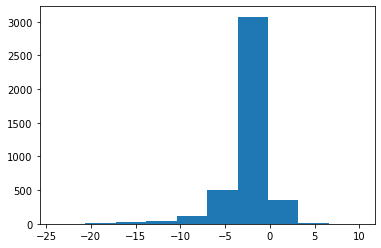

In [69]:
import matplotlib.pyplot as plt

plt.hist(df_result['Sales_PE'])

#df_result_test = run_clusters(which_model='test')



In [70]:
def only_enough_stat(df_tmp=df_result):
    df_true = df_tmp[df_tmp['has_enough_stat'] == True]
    return df_true


In [71]:
df_result_true = only_enough_stat(df_result)
#df_result_test_true = only_enough_stat(df_result_test)

(array([3.000e+00, 5.000e+00, 1.000e+00, 1.100e+01, 2.200e+01, 2.400e+01,
        4.000e+01, 6.400e+01, 1.360e+02, 3.970e+02, 1.176e+03, 4.880e+02,
        2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([-22.6431  , -20.719828, -18.796556, -16.873284, -14.950012,
        -13.02674 , -11.103468,  -9.180196,  -7.256924,  -5.333652,
         -3.41038 ,  -1.487108,   0.436164,   2.359436,   4.282708,
          6.20598 ,   8.129252,  10.052524,  11.975796,  13.899068,
         15.82234 ,  17.745612,  19.668884,  21.592156,  23.515428,
         25.4387  ]),
 <BarContainer object of 25 artists>)

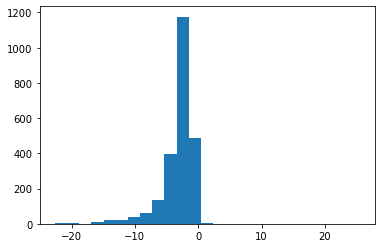

In [58]:
plt.hist(df_result_true['Sales_PE'], bins=25)

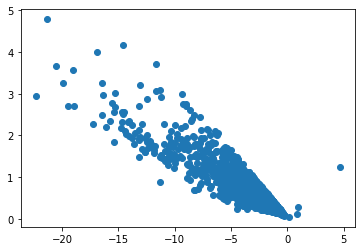

In [72]:
plt.scatter(df_result_true['Sales_PE'],df_result_true['Sales_PE_err'])

(array([1.000e+00, 1.000e+00, 1.000e+00, 7.000e+00, 1.000e+00, 3.000e+00,
        7.000e+00, 4.000e+00, 6.000e+00, 9.000e+00, 4.000e+01, 1.110e+02,
        6.620e+02, 1.453e+03, 2.700e+01, 1.500e+01, 8.000e+00, 5.000e+00,
        3.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00]),
 array([-0.9732  , -0.901156, -0.829112, -0.757068, -0.685024, -0.61298 ,
        -0.540936, -0.468892, -0.396848, -0.324804, -0.25276 , -0.180716,
        -0.108672, -0.036628,  0.035416,  0.10746 ,  0.179504,  0.251548,
         0.323592,  0.395636,  0.46768 ,  0.539724,  0.611768,  0.683812,
         0.755856,  0.8279  ]),
 <BarContainer object of 25 artists>)

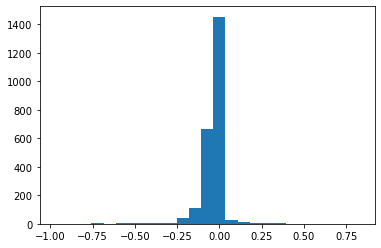

In [78]:
plt.hist(df_result_true['del_week'], bins=25)
#df_result_true['del_week'].min()


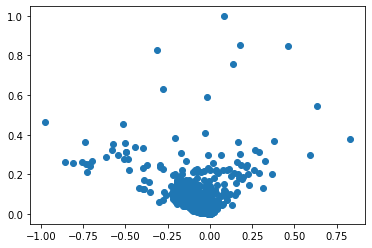

In [80]:
plt.scatter(df_result_true['del_week'],df_result_true['del_week_err'])

(array([  1.,   0.,   0.,   0.,   3., 220., 820., 557., 294., 173.,  98.,
         54.,  37.,  26.,  22.,  20.,  16.,  12.,   6.,   0.,   4.,   0.,
          4.,   0.,   1.]),
 array([-27.8614  , -22.066496, -16.271592, -10.476688,  -4.681784,
          1.11312 ,   6.908024,  12.702928,  18.497832,  24.292736,
         30.08764 ,  35.882544,  41.677448,  47.472352,  53.267256,
         59.06216 ,  64.857064,  70.651968,  76.446872,  82.241776,
         88.03668 ,  93.831584,  99.626488, 105.421392, 111.216296,
        117.0112  ]),
 <BarContainer object of 25 artists>)

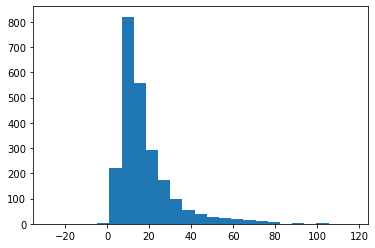

In [83]:
plt.hist(df_result_true['intercept'],bins=25)


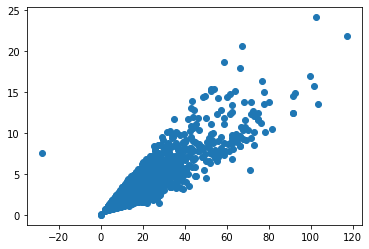

In [84]:
plt.scatter(df_result_true['intercept'], df_result_true['intercept_err'])

In [74]:
print(df_result_true['Sales_PE'].nlargest(10))
print(df_result_true['Sales_PE'].nsmallest(10))


000000001000083954    4.6820
000000001000080472    0.9588
000000001000080481    0.8745
000000001000010998    0.1330
000000001000136065   -0.2642
000000001000136054   -0.2716
000000001000136064   -0.2731
000000001000104421   -0.2752
000000001000092080   -0.3350
000000001000178649   -0.3451
Name: Sales_PE, dtype: float64
000000001000007431   -22.3379
000000001000215686   -21.3312
000000001000178468   -20.5756
000000001000007448   -19.9540
000000001000007432   -19.4548
000000001000034755   -19.0686
000000001000016117   -18.9379
000000001000117276   -17.2797
000000001000005341   -16.8662
000000001000006087   -16.4723
Name: Sales_PE, dtype: float64


In [101]:
def obtain_stats(df_tmp=df_result_true, which_model='test'):
    print('Model results: ', which_model)
    column = ''
    PE = ''
    if which_model == 'test':
        column = ['intercept', 'log_avg_sessions']
        PE = 'log_avg_sessions'
    elif which_model == 'std':
        column = ['intercept', 'Sales_PE', 'del_week']
        PE = ['Sales_PE']
    elif which_model == 'std_session':
        column = ['intercept', 'Sales_PE', 'del_week', 'log_avg_sessions']
        PE = ['Sales_PE']
    elif which_model == 'std_mkt_cost':
        column = ['intercept', 'Sales_PE', 'del_week', 'log_market_cost']
        PE = ['Sales_PE']
    print('Number of items = ', len(df_tmp.index))  #print number of items
    print('Max value = ', round(df_tmp[PE].max(), 3), ', Min value =', round(df_tmp[PE].min(), 3))  # print max & min
    #print(df_tmp[PE].nlargest(5),'\n',df_tmp[PE].nsmallest(5))
    import math
    for i in column:
        print(i)
        print('Mean\n', round(df_tmp[i].mean(), 3), '±', round(df_tmp[i].sem(), 3))
        print('Median\n ', round(df_tmp[i].median(), 3), '± ', round(1.253 * df_tmp[i].sem(), 3))
        print('\n')
    #print('Std ',round(df_tmp[column].std(),3))

In [102]:
obtain_stats(df_result_true, 'std')

Model results:  std
Number of items =  2368
Max value =  Sales_PE    4.682
dtype: float64 , Min value = Sales_PE   -22.338
dtype: float64
intercept
Mean
 18.037 ± 0.281
Median
  13.923 ±  0.352


Sales_PE
Mean
 -3.211 ± 0.055
Median
  -2.409 ±  0.069


del_week
Mean
 -0.04 ± 0.002
Median
  -0.025 ±  0.002




In [ ]:
#for outliers in df_result_true[(df_result_true['Sales_PE'] > 0.)].index:
#    print(outliers)
#    df_result_true.drop(index=outliers, inplace=True)


In [ ]:
#obtain_stats(df_result_true, 'std_mkt_cost')

In [85]:
df_result_true_final = df_result_true[
    ['Sales_PE', 'Sales_PE_err', 'del_week', 'del_week_err', 'intercept', 'intercept_err']]

In [86]:
df_result_true_final.head()


Sales_PE  Sales_PE_err  del_week  del_week_err  intercept  \
000000001000012530   -1.9986        0.3847   -0.0240        0.0169    11.0518   
000000001000021922   -2.3047        0.2505   -0.0345        0.0099    11.5462   
000000001000080319   -1.5376        0.3309   -0.0250        0.0074     9.3911   
000000001000125896   -0.5441        0.1666   -0.0100        0.0046     3.7622   
000000001000005727   -5.7456        1.1035   -0.0922        0.0790    29.4246   

                    intercept_err  
000000001000012530         1.9883  
000000001000021922         1.1942  
000000001000080319         1.9848  
000000001000125896         1.0965  
000000001000005727         5.0642

In [87]:
df_result_true_final.to_csv('./../raw_data/Excel_files/Top5k_Sales_PE_new_model_20210507.csv')


In [88]:
df_result_session = run_clusters(which_model = 'std_session')

Number of items passing the PE cut 4148
Intercept                             12.698232
C(item_code)[T.000000001000008806]    -0.305766
C(item_code)[T.000000001000012524]    -0.204877
C(item_code)[T.000000001000012530]    -1.221379
C(item_code)[T.000000001000012678]    -0.796632
C(item_code)[T.000000001000012683]    -0.686576
C(item_code)[T.000000001000012685]    -0.639614
C(item_code)[T.000000001000032634]     0.404030
C(item_code)[T.000000001000039127]     0.503827
C(item_code)[T.000000001000050966]    -1.298508
C(item_code)[T.000000001000104126]    -0.923865
C(item_code)[T.000000001000116650]    -0.326325
C(item_code)[T.000000001000118131]    -0.893277
C(item_code)[T.000000001000128965]    -0.055737
C(item_code)[T.000000001000150712]     0.699332
log_avg_sessions                      -0.076220
log_price                             -2.044917
delivery_weeks                        -0.023315
dtype: float64
12.698231996755993   -2.0449170944117427   -0.023314633521845627
Intercept       

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             6.248427
C(item_code)[T.000000001000050886]    0.476494
C(item_code)[T.000000001000150713]    0.991512
C(item_code)[T.000000001000166550]    0.367888
C(item_code)[T.000000001000178078]    0.330893
C(item_code)[T.000000001000178079]    0.049130
C(item_code)[T.000000001000178080]    0.107759
C(item_code)[T.000000001000182823]    0.685322
C(item_code)[T.000000001000223473]   -0.047000
log_avg_sessions                     -0.196390
log_price                            -0.400419
delivery_weeks                       -0.003274
dtype: float64
6.248427073846648   -0.40041925304295767   -0.0032744006232837443
Intercept                             15.941428
C(item_code)[T.000000001000052448]    -0.611342
C(item_code)[T.000000001000052581]    -0.694499
C(item_code)[T.000000001000052646]    -0.168576
C(item_code)[T.000000001000063626]    -0.386657
C(item_code)[T.000000001000063628]    -0.296145
C(item_code)[T.000000001000064349]    -0.109816
C(item_code)[T.0000

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             21.422778
C(item_code)[T.000000001000076754]     0.105132
C(item_code)[T.000000001000076755]     0.087682
C(item_code)[T.000000001000076760]     0.914340
C(item_code)[T.000000001000076780]     1.044935
C(item_code)[T.000000001000080045]     0.325696
C(item_code)[T.000000001000080376]     1.250439
C(item_code)[T.000000001000081875]     0.303712
C(item_code)[T.000000001000101668]    -0.159377
C(item_code)[T.000000001000121627]     0.550294
C(item_code)[T.000000001000121691]     0.331662
C(item_code)[T.000000001000133193]     0.779219
C(item_code)[T.000000001000133203]     0.719131
C(item_code)[T.000000001000136796]    -0.353037
C(item_code)[T.000000001000154789]    -0.093638
C(item_code)[T.000000001000214951]     0.061258
C(item_code)[T.000000001000214953]     0.035795
C(item_code)[T.000000001000221740]     0.943592
log_avg_sessions                      -0.677272
log_price                             -1.412439
delivery_weeks                        -0

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             11.222240
C(item_code)[T.000000001000015924]    -0.635713
C(item_code)[T.000000001000054177]    -1.758539
C(item_code)[T.000000001000054487]    -1.197395
C(item_code)[T.000000001000054489]    -0.977799
C(item_code)[T.000000001000064586]    -0.980148
C(item_code)[T.000000001000064588]    -1.002903
C(item_code)[T.000000001000064649]    -1.062202
C(item_code)[T.000000001000092536]    -1.434454
C(item_code)[T.000000001000123772]    -1.291448
C(item_code)[T.000000001000131842]    -1.320900
C(item_code)[T.000000001000182072]    -2.146297
C(item_code)[T.000000001000192755]    -1.516708
C(item_code)[T.000000001000202070]    -1.369229
C(item_code)[T.000000001000202077]    -1.474998
C(item_code)[T.000000001000202080]    -1.477276
C(item_code)[T.000000001000213257]    -1.898824
log_avg_sessions                      -0.197387
log_price                             -1.140636
delivery_weeks                        -0.023906
dtype: float64
11.222240185194032   -1.1

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept           25.272761
log_avg_sessions    -0.603865
log_price           -2.711631
delivery_weeks       0.011537
dtype: float64
25.27276143029789   -2.7116309071911857   0.01153690272703456
Intercept                             24.104601
C(item_code)[T.000000001000005759]    -0.309509
C(item_code)[T.000000001000005772]    -0.530788
C(item_code)[T.000000001000005775]     1.057609
C(item_code)[T.000000001000015613]     1.310159
C(item_code)[T.000000001000015629]     1.163735
C(item_code)[T.000000001000112672]     2.548961
C(item_code)[T.000000001000116741]    -0.268199
C(item_code)[T.000000001000123754]     2.072895
C(item_code)[T.000000001000138396]     2.796154
C(item_code)[T.000000001000161914]     0.991967
C(item_code)[T.000000001000167245]     2.708035
C(item_code)[T.000000001000171071]     1.128416
C(item_code)[T.000000001000179033]     1.514057
C(item_code)[T.000000001000218722]     3.059465
log_avg_sessions                      -0.728514
log_price                          

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             15.851338
C(item_code)[T.000000001000129535]    -1.389370
C(item_code)[T.000000001000137209]     7.466289
C(item_code)[T.000000001000176266]    -1.726193
C(item_code)[T.000000001000176291]     8.983698
C(item_code)[T.000000001000199233]    -3.692300
log_avg_sessions                       0.710249
log_price                             -5.583233
delivery_weeks                         0.068748
dtype: float64
15.851337702002102   -5.5832330932874   0.06874752989338773
Intercept                             5.017097
C(item_code)[T.000000001000127427]    0.012236
C(item_code)[T.000000001000187614]    0.490473
C(item_code)[T.000000001000187615]    0.314156
C(item_code)[T.000000001000193976]    0.256398
C(item_code)[T.000000001000200122]    0.290300
log_avg_sessions                     -0.205349
log_price                            -0.227626
delivery_weeks                       -0.023788
dtype: float64
5.0170971637116235   -0.22762559606586397   -0.02378780

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 1 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_res

Intercept                             19.161895
C(item_code)[T.000000001000007072]     1.089309
C(item_code)[T.000000001000008069]     0.257748
C(item_code)[T.000000001000008070]     0.474954
C(item_code)[T.000000001000039383]    -0.016740
C(item_code)[T.000000001000039495]     0.141533
C(item_code)[T.000000001000039550]    -0.832220
C(item_code)[T.000000001000048014]    -0.313122
C(item_code)[T.000000001000048015]    -0.058864
C(item_code)[T.000000001000059303]    -0.378456
C(item_code)[T.000000001000063626]    -0.072815
C(item_code)[T.000000001000064348]     0.294974
C(item_code)[T.000000001000087676]    -1.088228
C(item_code)[T.000000001000134815]    -0.100794
C(item_code)[T.000000001000134817]     0.732544
log_avg_sessions                      -0.392995
log_price                             -2.082120
delivery_weeks                        -0.042749
dtype: float64
19.161895170576546   -2.082120023602499   -0.04274860076355602
Intercept                             19.272856
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             41.843856
C(item_code)[T.000000001000123757]    -5.630290
C(item_code)[T.000000001000125113]     0.871993
C(item_code)[T.000000001000125117]    -3.147992
C(item_code)[T.000000001000138412]    -3.550369
C(item_code)[T.000000001000171107]     0.005031
C(item_code)[T.000000001000176221]    -2.988736
C(item_code)[T.000000001000176430]    -3.442485
C(item_code)[T.000000001000176747]     0.516728
C(item_code)[T.000000001000179468]    -5.602546
C(item_code)[T.000000001000184176]    -0.545951
C(item_code)[T.000000001000216151]    -0.712567
C(item_code)[T.000000001000216193]     0.537525
log_avg_sessions                      -0.157814
log_price                             -7.174489
delivery_weeks                        -0.028558
dtype: float64
41.84385634215125   -7.174488787007781   -0.02855823845737513
Intercept                             15.619179
C(item_code)[T.000000001000008815]     0.304445
C(item_code)[T.000000001000039131]    -0.347113
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             21.800912
C(item_code)[T.000000001000069226]     3.745091
C(item_code)[T.000000001000119744]     0.486655
C(item_code)[T.000000001000119757]     1.495220
C(item_code)[T.000000001000152766]    -0.175734
C(item_code)[T.000000001000171334]     1.132438
C(item_code)[T.000000001000177734]     0.422222
C(item_code)[T.000000001000177736]     1.029757
C(item_code)[T.000000001000177744]     0.210413
C(item_code)[T.000000001000186228]     0.614920
C(item_code)[T.000000001000223284]     0.723328
C(item_code)[T.000000001000223910]    -0.528604
log_avg_sessions                      -0.514594
log_price                             -2.052071
delivery_weeks                        -0.036725
dtype: float64
21.800911518449475   -2.052071420831156   -0.036725012448436255
Intercept                             13.177558
C(item_code)[T.000000001000008053]     0.045791
C(item_code)[T.000000001000015550]    -0.824130
C(item_code)[T.000000001000027404]     0.479625
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid

Intercept                             25.970541
C(item_code)[T.000000001000007072]     1.333564
C(item_code)[T.000000001000008069]     0.154002
C(item_code)[T.000000001000008072]    -0.074367
C(item_code)[T.000000001000015743]    -0.958668
C(item_code)[T.000000001000033653]    -2.241537
C(item_code)[T.000000001000039495]    -0.316185
C(item_code)[T.000000001000048013]    -0.632838
C(item_code)[T.000000001000048014]    -0.815632
C(item_code)[T.000000001000059300]    -3.044408
C(item_code)[T.000000001000064348]     0.557524
C(item_code)[T.000000001000123220]    -0.125121
C(item_code)[T.000000001000134819]    -0.365325
C(item_code)[T.000000001000150777]    -3.142017
C(item_code)[T.000000001000202186]    -1.046658
log_avg_sessions                      -0.385663
log_price                             -3.324110
delivery_weeks                        -0.069856
dtype: float64
25.970540900666517   -3.3241102469283366   -0.0698557275053304
Intercept                             13.957577
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid

Intercept                             25.508748
C(item_code)[T.000000001000008872]    -0.400327
C(item_code)[T.000000001000015708]    -0.096233
C(item_code)[T.000000001000047981]    -1.456958
C(item_code)[T.000000001000054500]    -3.475215
C(item_code)[T.000000001000057519]    -2.072043
C(item_code)[T.000000001000124600]    -0.975512
C(item_code)[T.000000001000124603]    -1.152448
C(item_code)[T.000000001000131647]    -3.464523
C(item_code)[T.000000001000131652]    -3.280217
C(item_code)[T.000000001000156830]    -2.654370
C(item_code)[T.000000001000168496]    -1.988359
C(item_code)[T.000000001000170728]    -1.801008
C(item_code)[T.000000001000172758]    -1.600882
C(item_code)[T.000000001000204350]    -1.256662
C(item_code)[T.000000001000205550]    -1.668503
C(item_code)[T.000000001000205566]    -2.009078
C(item_code)[T.000000001000211591]    -1.568941
C(item_code)[T.000000001000211718]    -1.544332
C(item_code)[T.000000001000214062]    -2.308193
log_avg_sessions                      -0

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "



8.480689471017854   -1.2920131822707819   -0.09319262968024686
Intercept                             5.210691
C(item_code)[T.000000001000110071]   -1.642564
C(item_code)[T.000000001000110918]   -1.190387
C(item_code)[T.000000001000129416]    1.200863
C(item_code)[T.000000001000149292]   -0.252697
C(item_code)[T.000000001000150442]   -1.109541
C(item_code)[T.000000001000160306]   -0.618774
C(item_code)[T.000000001000178362]    0.553301
log_avg_sessions                      0.437797
log_price                            -2.571424
delivery_weeks                       -0.187248
dtype: float64
5.210691102617867   -2.57142405735508   -0.18724751759255653
Intercept          -11.553401
log_avg_sessions    -0.020340
log_price            2.314722
delivery_weeks      -0.051436
dtype: float64
-11.553400518421611   2.3147216926855627   -0.05143636157452627
Intercept                             19.158582
C(item_code)[T.000000001000072322]    -0.564930
C(item_code)[T.000000001000076800]    -2.056118


/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             26.260381
C(item_code)[T.000000001000024955]    -3.755681
C(item_code)[T.000000001000037853]    -4.559841
C(item_code)[T.000000001000037861]    -4.635665
C(item_code)[T.000000001000037869]    -4.391877
C(item_code)[T.000000001000091266]    -2.321663
log_avg_sessions                      -0.987360
log_price                             -0.674697
delivery_weeks                        -0.035087
dtype: float64
26.26038114113488   -0.6746965277015731   -0.03508699300159099
Intercept                             21.702234
C(item_code)[T.000000001000047023]     3.019820
C(item_code)[T.000000001000047024]     1.253963
C(item_code)[T.000000001000056200]     6.375083
C(item_code)[T.000000001000123023]     1.697710
C(item_code)[T.000000001000128735]     1.224701
C(item_code)[T.000000001000128736]     2.719912
C(item_code)[T.000000001000149058]     5.284515
C(item_code)[T.000000001000167517]     1.306280
C(item_code)[T.000000001000167557]     3.443959
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             11.086310
C(item_code)[T.000000001000076413]    -0.113660
C(item_code)[T.000000001000076611]    -0.095058
C(item_code)[T.000000001000076756]     0.136897
C(item_code)[T.000000001000080300]    -0.016589
C(item_code)[T.000000001000080364]    -0.363913
C(item_code)[T.000000001000081920]    -0.134621
C(item_code)[T.000000001000081924]    -0.182879
C(item_code)[T.000000001000101016]    -0.048231
C(item_code)[T.000000001000101053]    -0.267317
C(item_code)[T.000000001000101087]     0.064253
C(item_code)[T.000000001000101103]     1.235797
C(item_code)[T.000000001000101110]     0.265762
C(item_code)[T.000000001000133159]    -0.204306
C(item_code)[T.000000001000133161]    -0.051279
C(item_code)[T.000000001000136121]     0.264758
C(item_code)[T.000000001000174532]     0.144336
log_avg_sessions                      -0.328634
log_price                             -0.794122
delivery_weeks                        -0.013890
dtype: float64
11.086310330152006   -0.7

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 1 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


Intercept                             11.381197
C(item_code)[T.000000001000047114]    -0.943799
C(item_code)[T.000000001000047118]    -1.069914
C(item_code)[T.000000001000104200]    -0.293804
C(item_code)[T.000000001000104324]    -1.011517
C(item_code)[T.000000001000118143]     0.624896
C(item_code)[T.000000001000123635]    -0.790572
C(item_code)[T.000000001000127099]    -0.745248
C(item_code)[T.000000001000147247]    -0.655260
C(item_code)[T.000000001000148112]    -1.273211
C(item_code)[T.000000001000178027]    -0.804886
C(item_code)[T.000000001000181275]    -1.207716
C(item_code)[T.000000001000187565]    -1.123495
C(item_code)[T.000000001000187580]    -1.495937
log_avg_sessions                      -0.243191
log_price                             -0.979284
delivery_weeks                        -0.025429
dtype: float64
11.38119709711172   -0.9792840021177504   -0.02542925537725574
Intercept                             25.736200
C(item_code)[T.000000001000027340]    -0.181342
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             20.672893
C(item_code)[T.000000001000052436]    -4.412959
C(item_code)[T.000000001000052437]    -3.177895
C(item_code)[T.000000001000052644]    -3.805410
C(item_code)[T.000000001000052645]    -2.880544
C(item_code)[T.000000001000098558]    -1.593896
C(item_code)[T.000000001000123634]    -1.375527
C(item_code)[T.000000001000123809]    -1.725806
C(item_code)[T.000000001000125633]    -1.038625
C(item_code)[T.000000001000125757]    -2.543041
C(item_code)[T.000000001000126876]    -1.735488
C(item_code)[T.000000001000127553]    -2.376818
C(item_code)[T.000000001000129138]    -3.781875
C(item_code)[T.000000001000145313]    -1.220815
C(item_code)[T.000000001000159195]    -3.051414
C(item_code)[T.000000001000184269]    -2.133229
C(item_code)[T.000000001000209069]    -3.455065
C(item_code)[T.000000001000209810]    -2.617790
log_avg_sessions                      -0.128063
log_price                             -2.532799
delivery_weeks                        -0

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept           7.206263
log_avg_sessions   -0.261956
log_price          -0.392478
delivery_weeks      0.004270
dtype: float64
7.206262561424667   -0.3924778083899416   0.004269654676844623
Intercept                             28.545378
C(item_code)[T.000000001000096428]     1.860048
C(item_code)[T.000000001000096476]     1.790541
C(item_code)[T.000000001000096497]     3.036014
C(item_code)[T.000000001000096508]     1.545121
C(item_code)[T.000000001000096511]     0.860926
C(item_code)[T.000000001000129053]     0.426809
C(item_code)[T.000000001000198945]    -1.590191
log_avg_sessions                      -0.556330
log_price                             -3.506825
delivery_weeks                        -0.115927
dtype: float64
28.54537828573645   -3.5068253937847955   -0.1159273455169107
Intercept                             47.984989
C(item_code)[T.000000001000008754]    -0.062689
C(item_code)[T.000000001000008841]    -7.026270
C(item_code)[T.000000001000008845]    -1.966475
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             43.507239
C(item_code)[T.000000001000133273]     2.598151
C(item_code)[T.000000001000134310]    -2.378311
C(item_code)[T.000000001000134872]    -0.256133
C(item_code)[T.000000001000142801]     0.915400
C(item_code)[T.000000001000153542]     3.741659
C(item_code)[T.000000001000182151]    -1.421119
C(item_code)[T.000000001000188378]    -0.840536
C(item_code)[T.000000001000188476]    -1.708857
C(item_code)[T.000000001000188542]     1.259361
C(item_code)[T.000000001000208185]    -1.160900
C(item_code)[T.000000001000225035]    -1.007001
C(item_code)[T.000000001000225037]    -1.076506
log_avg_sessions                      -1.129494
log_price                             -4.870180
delivery_weeks                        -0.509182
dtype: float64
43.50723909896874   -4.8701803960346925   -0.5091816289003426
Intercept                             42.145831
C(item_code)[T.000000001000007435]    -2.054120
C(item_code)[T.000000001000112669]     2.224030
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             15.734301
C(item_code)[T.000000001000020148]    -1.174971
C(item_code)[T.000000001000030932]    -1.753793
C(item_code)[T.000000001000094666]    -2.097560
C(item_code)[T.000000001000094670]    -1.247640
C(item_code)[T.000000001000119220]    -1.943365
C(item_code)[T.000000001000119233]    -1.792438
C(item_code)[T.000000001000119239]    -1.574816
C(item_code)[T.000000001000119248]    -1.850328
C(item_code)[T.000000001000119265]    -1.561739
log_avg_sessions                      -0.379381
log_price                             -1.022431
delivery_weeks                        -0.037561
dtype: float64
15.734301135444536   -1.0224311155142878   -0.037561064375705014
Intercept                             15.911178
C(item_code)[T.000000001000008013]    -0.540700
C(item_code)[T.000000001000097482]     0.201172
C(item_code)[T.000000001000113296]     0.711681
C(item_code)[T.000000001000119257]     0.283199
C(item_code)[T.000000001000119258]    -0.850308
C(item_c

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "



14.12262346838125   -1.2915232903505582   -0.045409756492951675
Intercept                             14.347921
C(item_code)[T.000000001000053650]    -0.525203
C(item_code)[T.000000001000113241]    -0.491789
C(item_code)[T.000000001000127680]     0.220428
C(item_code)[T.000000001000131116]    -0.475350
log_avg_sessions                      -0.393548
log_price                             -0.883809
delivery_weeks                        -0.014802
dtype: float64
14.347920594371928   -0.883808689248013   -0.014802036408535571
Intercept                             2.947700
C(item_code)[T.000000001000052258]    0.208268
C(item_code)[T.000000001000052259]    0.068457
C(item_code)[T.000000001000056764]    0.106281
C(item_code)[T.000000001000063952]    0.170129
C(item_code)[T.000000001000064074]    0.154619
C(item_code)[T.000000001000064477]    0.338960
C(item_code)[T.000000001000084253]    0.233321
C(item_code)[T.000000001000119492]    0.493772
C(item_code)[T.000000001000119756]    0.303199
C(

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             16.294052
C(item_code)[T.000000001000012791]     0.248921
C(item_code)[T.000000001000012809]    -0.017657
C(item_code)[T.000000001000032623]     0.755509
C(item_code)[T.000000001000131876]    -0.637281
C(item_code)[T.000000001000137901]    -0.082159
C(item_code)[T.000000001000137913]    -1.225722
C(item_code)[T.000000001000145003]    -0.894594
C(item_code)[T.000000001000145006]    -0.837964
C(item_code)[T.000000001000145012]    -0.754322
C(item_code)[T.000000001000149755]    -0.295216
C(item_code)[T.000000001000167289]    -0.026433
C(item_code)[T.000000001000178745]    -0.611188
log_avg_sessions                      -0.473049
log_price                             -1.110451
delivery_weeks                        -0.020635
dtype: float64
16.29405153232585   -1.1104505365415671   -0.020635086068404584
Intercept                             5.018826
C(item_code)[T.000000001000027371]    0.471772
C(item_code)[T.000000001000027408]   -0.275340
C(item_code)

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "



10.76709055651124   -1.8599008877143017   10.767090556511228
Intercept                             25.276938
C(item_code)[T.000000001000098189]    -0.781951
C(item_code)[T.000000001000098190]     4.001639
C(item_code)[T.000000001000098206]    10.115932
C(item_code)[T.000000001000098239]     2.321677
C(item_code)[T.000000001000109927]     3.468080
C(item_code)[T.000000001000109988]    -0.077051
C(item_code)[T.000000001000110005]     1.351732
C(item_code)[T.000000001000137307]     0.802729
C(item_code)[T.000000001000149145]    -0.137352
C(item_code)[T.000000001000149149]     0.658410
C(item_code)[T.000000001000188280]     0.588557
log_avg_sessions                      -0.325379
log_price                             -4.540015
delivery_weeks                        -0.497254
dtype: float64
25.276937645137476   -4.540014785017229   -0.49725372285855307
Intercept                             22.425197
C(item_code)[T.000000001000021703]     0.803997
C(item_code)[T.000000001000054947]     1.564

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             19.312878
C(item_code)[T.000000001000030909]     0.181128
C(item_code)[T.000000001000086543]     1.215379
C(item_code)[T.000000001000103647]     0.926011
C(item_code)[T.000000001000103648]     0.889308
C(item_code)[T.000000001000126091]    -0.004436
C(item_code)[T.000000001000126203]     1.621305
C(item_code)[T.000000001000126915]     0.133110
C(item_code)[T.000000001000126927]     0.028514
C(item_code)[T.000000001000127939]     0.685791
C(item_code)[T.000000001000127956]     0.456239
C(item_code)[T.000000001000127964]     0.685153
C(item_code)[T.000000001000174658]     1.351553
log_avg_sessions                      -0.351762
log_price                             -2.218206
delivery_weeks                        -0.058259
dtype: float64
19.312878157372847   -2.2182064795913123   -0.05825917623117541
Intercept                             13.350978
C(item_code)[T.000000001000129382]     0.640175
C(item_code)[T.000000001000133271]    -0.368370
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             11.405960
C(item_code)[T.000000001000008032]     0.236467
C(item_code)[T.000000001000008526]    -0.034794
C(item_code)[T.000000001000056727]    -1.015954
C(item_code)[T.000000001000104259]    -0.338954
C(item_code)[T.000000001000104263]     0.120918
C(item_code)[T.000000001000104293]    -0.369939
C(item_code)[T.000000001000104316]     1.913812
C(item_code)[T.000000001000114940]    -1.390024
C(item_code)[T.000000001000116703]    -0.329446
C(item_code)[T.000000001000116705]    -0.474478
C(item_code)[T.000000001000149706]     0.029704
C(item_code)[T.000000001000163206]    -0.686444
C(item_code)[T.000000001000169032]    -0.604677
C(item_code)[T.000000001000211602]    -0.646589
log_avg_sessions                      -0.282536
log_price                             -0.983054
delivery_weeks                        -0.061675
dtype: float64
11.405960112507948   -0.9830539112904065   -0.06167510475301036
Intercept                             10.548530
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  re

Intercept                             10.189186
C(item_code)[T.000000001000032335]    -0.586974
C(item_code)[T.000000001000110912]    -1.211191
C(item_code)[T.000000001000110913]     0.218451
C(item_code)[T.000000001000110918]    -0.406461
C(item_code)[T.000000001000130641]    -0.728815
C(item_code)[T.000000001000130645]     0.644993
C(item_code)[T.000000001000130672]    -1.357409
C(item_code)[T.000000001000163073]     0.227834
C(item_code)[T.000000001000178362]     1.078998
C(item_code)[T.000000001000196884]    -0.409846
log_avg_sessions                      -0.001497
log_price                             -2.105896
delivery_weeks                         0.020366
dtype: float64
10.189185798820432   -2.10589615788762   0.02036585402800234
Intercept                             16.400556
C(item_code)[T.000000001000012641]    -1.575238
C(item_code)[T.000000001000039123]    -0.898798
C(item_code)[T.000000001000039722]    -1.319987
C(item_code)[T.000000001000109884]    -0.319950
C(item_code)

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:762: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(SSR) * nobs2      # concen

Intercept                             27.183856
C(item_code)[T.000000001000008867]     2.611764
C(item_code)[T.000000001000008868]     2.843852
C(item_code)[T.000000001000008869]     2.487830
C(item_code)[T.000000001000008872]     1.349773
C(item_code)[T.000000001000039137]     0.981226
C(item_code)[T.000000001000040399]     0.266992
C(item_code)[T.000000001000050847]     0.984238
C(item_code)[T.000000001000050880]    -4.265804
C(item_code)[T.000000001000050881]    -1.651888
C(item_code)[T.000000001000123250]    -0.207139
C(item_code)[T.000000001000125845]     0.119375
C(item_code)[T.000000001000147153]     1.626030
C(item_code)[T.000000001000147156]     1.234524
C(item_code)[T.000000001000149752]     0.178457
C(item_code)[T.000000001000178069]     0.030398
C(item_code)[T.000000001000179342]    -4.243361
C(item_code)[T.000000001000204356]     0.022481
C(item_code)[T.000000001000211591]    -0.426786
log_avg_sessions                      -0.270009
log_price                             -3

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             13.824413
C(item_code)[T.000000001000008048]    -0.408712
C(item_code)[T.000000001000064222]     0.589929
C(item_code)[T.000000001000064530]     0.369916
C(item_code)[T.000000001000064531]     0.780708
C(item_code)[T.000000001000069118]     1.581413
C(item_code)[T.000000001000119754]     0.488593
C(item_code)[T.000000001000152587]     0.293260
C(item_code)[T.000000001000172407]    -0.421997
C(item_code)[T.000000001000173643]    -0.468582
C(item_code)[T.000000001000178634]    -0.317652
C(item_code)[T.000000001000182822]     1.108346
C(item_code)[T.000000001000191237]     0.503887
C(item_code)[T.000000001000225832]    -0.062866
log_avg_sessions                      -0.235027
log_price                             -1.562871
delivery_weeks                        -0.036862
dtype: float64
13.824412502766066   -1.562870611477359   -0.03686164984112289
Intercept                             5.878470
C(item_code)[T.000000001000052472]   -0.540668
C(item_code)

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             11.983232
C(item_code)[T.000000001000007593]     0.133589
C(item_code)[T.000000001000007597]     1.082580
C(item_code)[T.000000001000015772]     0.830523
C(item_code)[T.000000001000015786]     0.430283
C(item_code)[T.000000001000051913]     2.013857
C(item_code)[T.000000001000086534]     0.890815
C(item_code)[T.000000001000126203]     1.855033
C(item_code)[T.000000001000127855]     0.233962
C(item_code)[T.000000001000127864]     0.659732
C(item_code)[T.000000001000127878]     0.453374
C(item_code)[T.000000001000127882]     0.221189
C(item_code)[T.000000001000129084]     1.417597
C(item_code)[T.000000001000145317]     0.406046
C(item_code)[T.000000001000174653]     0.582794
C(item_code)[T.000000001000174666]    -0.050551
C(item_code)[T.000000001000182528]     1.068034
C(item_code)[T.000000001000186229]     0.235026
C(item_code)[T.000000001000189271]     0.968979
C(item_code)[T.000000001000206997]     1.498973
log_avg_sessions                      -0

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             10.882732
C(item_code)[T.000000001000039125]     0.346084
C(item_code)[T.000000001000109884]     0.450014
C(item_code)[T.000000001000117169]    -0.291675
C(item_code)[T.000000001000119614]    -0.905713
C(item_code)[T.000000001000121274]     1.206305
C(item_code)[T.000000001000126041]     1.113463
C(item_code)[T.000000001000152214]    -0.478577
C(item_code)[T.000000001000163192]    -0.690504
C(item_code)[T.000000001000171219]    -0.129208
C(item_code)[T.000000001000176898]     0.152665
C(item_code)[T.000000001000191062]     0.699779
C(item_code)[T.000000001000201158]     0.863791
C(item_code)[T.000000001000210750]     0.731205
C(item_code)[T.000000001000211513]     0.309309
log_avg_sessions                      -0.123358
log_price                             -1.296268
delivery_weeks                        -0.029332
dtype: float64
10.88273173174775   -1.2962676470224683   -0.029332198362674058
Intercept                             18.610433
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             25.965644
C(item_code)[T.000000001000008058]     0.046282
C(item_code)[T.000000001000008072]    -1.252649
C(item_code)[T.000000001000015743]    -2.121083
C(item_code)[T.000000001000033653]    -3.480149
C(item_code)[T.000000001000039495]    -1.567159
C(item_code)[T.000000001000048014]    -2.022503
C(item_code)[T.000000001000048017]    -0.773017
C(item_code)[T.000000001000059300]    -4.334661
C(item_code)[T.000000001000123077]    -4.781502
C(item_code)[T.000000001000123131]    -4.377108
C(item_code)[T.000000001000125029]    -3.694307
C(item_code)[T.000000001000125030]    -5.107718
C(item_code)[T.000000001000134815]    -1.418837
C(item_code)[T.000000001000150777]    -4.260614
C(item_code)[T.000000001000167755]    -3.609927
log_avg_sessions                      -0.375929
log_price                             -3.132069
delivery_weeks                        -0.029930
dtype: float64
25.96564401156263   -3.1320690248089824   -0.029929969336206348
Intercept

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             29.159875
C(item_code)[T.000000001000016022]     4.433335
C(item_code)[T.000000001000016023]     2.192268
C(item_code)[T.000000001000016025]    -0.976230
C(item_code)[T.000000001000016139]     3.680928
C(item_code)[T.000000001000054046]     0.678378
C(item_code)[T.000000001000054423]    -0.162757
C(item_code)[T.000000001000054424]     0.849359
C(item_code)[T.000000001000128742]     0.742743
C(item_code)[T.000000001000128745]     0.785954
C(item_code)[T.000000001000128755]     1.253078
C(item_code)[T.000000001000176706]     0.512304
C(item_code)[T.000000001000179058]     2.279257
C(item_code)[T.000000001000191041]     0.251760
C(item_code)[T.000000001000208975]    -1.777597
C(item_code)[T.000000001000216190]    -0.406848
C(item_code)[T.000000001000216193]     0.659686
log_avg_sessions                      -0.820624
log_price                             -2.615424
delivery_weeks                        -0.016915
dtype: float64
29.159875152203714   -2.6

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             7.323383
C(item_code)[T.000000001000071165]    0.514834
C(item_code)[T.000000001000094955]   -0.133168
C(item_code)[T.000000001000113354]    0.227846
C(item_code)[T.000000001000175787]    0.109510
log_avg_sessions                     -0.149335
log_price                            -0.655758
delivery_weeks                       -0.005161
dtype: float64
7.323382699714593   -0.6557583136871954   -0.005161090406263937
Intercept                             10.472555
C(item_code)[T.000000001000192380]     1.557600
C(item_code)[T.000000001000193606]     1.094478
C(item_code)[T.000000001000208710]    -2.732143
C(item_code)[T.000000001000215132]     0.549949
log_avg_sessions                      -1.242807
log_price                              2.153296
delivery_weeks                        -0.090340
dtype: float64
10.47255473332058   2.1532958588046287   -0.09034025420021188
Intercept                             11.071295
C(item_code)[T.000000001000008863]  

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             26.321736
C(item_code)[T.000000001000097482]     2.145814
C(item_code)[T.000000001000113296]     2.089404
C(item_code)[T.000000001000119257]     1.219498
C(item_code)[T.000000001000119258]    -0.287412
log_avg_sessions                      -0.492436
log_price                             -2.878316
delivery_weeks                        -0.126155
dtype: float64
26.321736160058034   -2.878315977095384   -0.12615511257849596
Intercept                            -5.423862
C(item_code)[T.000000001000027051]   -3.932990
C(item_code)[T.000000001000166798]   -4.995908
C(item_code)[T.000000001000183448]   -3.726963
C(item_code)[T.000000001000189750]   -2.164918
log_avg_sessions                     -0.983626
log_price                             3.711183
delivery_weeks                       -0.018358
dtype: float64
-5.423862265127536   3.711183006465713   -0.018358122865693344
Intercept                             17.011581
C(item_code)[T.000000001000021833]  

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             46.117285
C(item_code)[T.000000001000007435]    -2.048985
C(item_code)[T.000000001000016096]    -1.136600
C(item_code)[T.000000001000016139]     2.218845
C(item_code)[T.000000001000117275]    -1.019467
C(item_code)[T.000000001000123817]    -1.995092
C(item_code)[T.000000001000123847]    -0.761183
C(item_code)[T.000000001000126061]    -1.931025
C(item_code)[T.000000001000138433]    -1.706317
C(item_code)[T.000000001000165503]     0.089621
C(item_code)[T.000000001000179467]    -2.389269
C(item_code)[T.000000001000183898]    -1.252679
C(item_code)[T.000000001000184193]    -3.139651
C(item_code)[T.000000001000216192]     1.707437
log_avg_sessions                      -1.340140
log_price                             -3.719159
delivery_weeks                        -0.173642
dtype: float64
46.11728494191181   -3.719159445795267   -0.17364239804232015
Intercept                             15.616706
C(item_code)[T.000000001000076607]     0.310744
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid

Intercept                             34.630105
C(item_code)[T.000000001000015198]     1.424661
C(item_code)[T.000000001000034557]     1.099565
C(item_code)[T.000000001000053584]    -0.505018
C(item_code)[T.000000001000053671]     0.198408
C(item_code)[T.000000001000073168]     1.265321
C(item_code)[T.000000001000073182]     0.466432
C(item_code)[T.000000001000128818]     0.400885
C(item_code)[T.000000001000130676]     0.344717
C(item_code)[T.000000001000172942]     0.767733
C(item_code)[T.000000001000172943]     0.231419
log_avg_sessions                      -0.563300
log_price                             -3.802221
delivery_weeks                        -0.020840
dtype: float64
34.630105451847136   -3.802221397743223   -0.020840115552712625
Intercept                             18.541237
C(item_code)[T.000000001000076731]     0.210741
C(item_code)[T.000000001000076754]    -0.051477
C(item_code)[T.000000001000076760]     0.735331
C(item_code)[T.000000001000076844]    -0.256573
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             2.303770
C(item_code)[T.000000001000021877]    0.023790
C(item_code)[T.000000001000076521]    0.159050
C(item_code)[T.000000001000076851]    0.225642
C(item_code)[T.000000001000076853]    0.146344
C(item_code)[T.000000001000079568]    0.053670
C(item_code)[T.000000001000079572]    0.039529
C(item_code)[T.000000001000101043]    0.071462
C(item_code)[T.000000001000101235]    0.174864
C(item_code)[T.000000001000101236]    0.152397
C(item_code)[T.000000001000121609]    0.231018
C(item_code)[T.000000001000123326]    0.155305
C(item_code)[T.000000001000131585]    0.318487
C(item_code)[T.000000001000175587]    0.013758
C(item_code)[T.000000001000175589]    0.248268
C(item_code)[T.000000001000175611]    0.277528
C(item_code)[T.000000001000175614]    0.269817
C(item_code)[T.000000001000180154]    0.023103
C(item_code)[T.000000001000216098]    0.291925
log_avg_sessions                     -0.031058
log_price                            -0.276204
delivery_week

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             29.105182
C(item_code)[T.000000001000073158]     0.395659
C(item_code)[T.000000001000073159]     0.480238
C(item_code)[T.000000001000073164]    -0.762329
C(item_code)[T.000000001000085324]    -1.447118
C(item_code)[T.000000001000094684]    -0.798351
C(item_code)[T.000000001000125780]     0.636432
C(item_code)[T.000000001000128818]    -0.262050
C(item_code)[T.000000001000172911]     0.676470
C(item_code)[T.000000001000172950]    -0.418806
log_avg_sessions                      -0.618681
log_price                             -2.648505
delivery_weeks                        -0.025466
dtype: float64
29.105181525740733   -2.648505230312881   -0.025465501056835482
Intercept                             32.927682
C(item_code)[T.000000001000008063]    -3.067806
C(item_code)[T.000000001000008077]     0.103123
C(item_code)[T.000000001000008078]     1.572609
C(item_code)[T.000000001000008080]     0.355705
C(item_code)[T.000000001000015743]    -3.117705
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             29.361543
C(item_code)[T.000000001000054418]    -6.646033
C(item_code)[T.000000001000059370]    -6.767968
C(item_code)[T.000000001000059372]    -2.879774
C(item_code)[T.000000001000116755]    -8.339224
C(item_code)[T.000000001000117683]    -3.929291
C(item_code)[T.000000001000123742]    -6.568455
C(item_code)[T.000000001000128743]    -6.851579
C(item_code)[T.000000001000128764]    -6.285423
C(item_code)[T.000000001000128953]    -6.652053
C(item_code)[T.000000001000170681]    -6.435493
C(item_code)[T.000000001000170692]    -6.737662
C(item_code)[T.000000001000202053]    -7.783095
C(item_code)[T.000000001000226000]    -6.388416
log_avg_sessions                      -0.132006
log_price                             -3.878963
delivery_weeks                        -0.038438
dtype: float64
29.36154275472901   -3.8789629657498974   -0.03843750000451915
Intercept                             17.042885
C(item_code)[T.000000001000079675]    -2.261240
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             7.024723
C(item_code)[T.000000001000008809]    1.466645
C(item_code)[T.000000001000008814]    0.578997
C(item_code)[T.000000001000039135]    0.326341
C(item_code)[T.000000001000050867]    0.687527
C(item_code)[T.000000001000050952]    0.496730
C(item_code)[T.000000001000117190]    0.389968
C(item_code)[T.000000001000126038]    0.243454
C(item_code)[T.000000001000126039]    0.175666
C(item_code)[T.000000001000166778]    0.236108
C(item_code)[T.000000001000166781]    0.222473
C(item_code)[T.000000001000176687]    0.111778
C(item_code)[T.000000001000180840]   -0.015392
C(item_code)[T.000000001000182822]    0.803825
C(item_code)[T.000000001000182841]    0.207049
C(item_code)[T.000000001000207058]    0.627796
log_avg_sessions                     -0.093031
log_price                            -0.836557
delivery_weeks                       -0.031194
dtype: float64
7.024722855578635   -0.8365568927430439   -0.031193807597673553
Intercept                   

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             32.497416
C(item_code)[T.000000001000016101]     5.757187
C(item_code)[T.000000001000054049]     2.572347
C(item_code)[T.000000001000054418]     1.065735
C(item_code)[T.000000001000059372]     4.817066
C(item_code)[T.000000001000112678]     0.656526
C(item_code)[T.000000001000117258]     3.007774
C(item_code)[T.000000001000117683]     3.877471
C(item_code)[T.000000001000123742]     1.074071
C(item_code)[T.000000001000128743]     0.799079
C(item_code)[T.000000001000128764]     1.415000
C(item_code)[T.000000001000167714]     3.781048
C(item_code)[T.000000001000170692]     0.970581
C(item_code)[T.000000001000184095]    -0.518141
C(item_code)[T.000000001000202053]    -0.211180
log_avg_sessions                      -0.678845
log_price                             -3.997989
delivery_weeks                        -0.052744
dtype: float64
32.497416490052515   -3.997988737416429   -0.0527441754501193
Intercept                             13.149504
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             12.720251
C(item_code)[T.000000001000109909]     2.972469
C(item_code)[T.000000001000109911]     1.509420
C(item_code)[T.000000001000114079]     1.829753
C(item_code)[T.000000001000117186]     3.029217
C(item_code)[T.000000001000123447]     2.560934
C(item_code)[T.000000001000123449]     2.158647
C(item_code)[T.000000001000123522]     2.646990
C(item_code)[T.000000001000129702]     0.508511
C(item_code)[T.000000001000150467]     0.622189
C(item_code)[T.000000001000152836]     1.515384
C(item_code)[T.000000001000178608]     2.993566
C(item_code)[T.000000001000194258]     1.390139
C(item_code)[T.000000001000209635]     1.847812
C(item_code)[T.000000001000214949]     2.426720
log_avg_sessions                      -0.157830
log_price                             -2.251930
delivery_weeks                        -0.049851
dtype: float64
12.720250851920312   -2.2519300793625154   -0.04985087371055294
Intercept                             15.891676
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             17.290897
C(item_code)[T.000000001000117699]     1.094027
C(item_code)[T.000000001000137304]    -0.368548
C(item_code)[T.000000001000153506]    -0.264670
C(item_code)[T.000000001000153558]    -0.328260
C(item_code)[T.000000001000156992]     0.519969
C(item_code)[T.000000001000156999]     0.936798
C(item_code)[T.000000001000157000]    -1.459614
C(item_code)[T.000000001000157002]     0.744755
C(item_code)[T.000000001000157274]    -0.404872
C(item_code)[T.000000001000160416]    -0.599687
C(item_code)[T.000000001000179649]    -1.486305
C(item_code)[T.000000001000179650]     0.472865
C(item_code)[T.000000001000179652]     0.886198
C(item_code)[T.000000001000182946]     0.919885
C(item_code)[T.000000001000187382]    -0.025219
C(item_code)[T.000000001000187400]    -0.192657
C(item_code)[T.000000001000188310]     0.335966
C(item_code)[T.000000001000188390]     0.992155
C(item_code)[T.000000001000200431]    -0.532056
log_avg_sessions                      -0

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             30.996773
C(item_code)[T.000000001000063602]    -0.792967
C(item_code)[T.000000001000064394]    -0.256320
C(item_code)[T.000000001000168550]    -2.000541
C(item_code)[T.000000001000168572]    -2.531001
C(item_code)[T.000000001000168580]    -0.211412
C(item_code)[T.000000001000175274]    -0.813853
C(item_code)[T.000000001000175282]    -0.686588
C(item_code)[T.000000001000175284]    -1.028491
C(item_code)[T.000000001000198943]    -1.134062
C(item_code)[T.000000001000198945]    -3.985712
C(item_code)[T.000000001000210724]    -1.201676
C(item_code)[T.000000001000211328]    -1.195965
C(item_code)[T.000000001000211342]    -0.727386
log_avg_sessions                      -0.671430
log_price                             -3.007955
delivery_weeks                        -0.138427
dtype: float64
30.996773449814803   -3.007955222137009   -0.138426777775534
Intercept                             11.131827
C(item_code)[T.000000001000020148]     0.195773
C(item_code)

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             30.290021
C(item_code)[T.000000001000008550]    -1.007657
C(item_code)[T.000000001000065870]    -1.674469
C(item_code)[T.000000001000210465]     0.331777
log_avg_sessions                      -0.081910
log_price                             -4.044747
delivery_weeks                        -0.120506
dtype: float64
30.29002078729387   -4.044746876958071   -0.12050588856979641
Intercept                             25.879711
C(item_code)[T.000000001000054376]    -0.111360
C(item_code)[T.000000001000054377]    -0.003226
C(item_code)[T.000000001000069675]     4.123936
C(item_code)[T.000000001000110046]    -1.243275
C(item_code)[T.000000001000110081]    -0.040619
C(item_code)[T.000000001000118448]    -0.665590
C(item_code)[T.000000001000120926]    -1.392942
C(item_code)[T.000000001000123550]     1.036383
C(item_code)[T.000000001000124781]    -1.411910
C(item_code)[T.000000001000153511]    -0.478311
C(item_code)[T.000000001000168742]    -0.867852
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             1.690824
C(item_code)[T.000000001000030870]   -0.156929
C(item_code)[T.000000001000030876]    0.021559
C(item_code)[T.000000001000030982]    0.079273
C(item_code)[T.000000001000031385]   -0.032200
C(item_code)[T.000000001000031389]    0.018019
C(item_code)[T.000000001000040784]   -0.164568
C(item_code)[T.000000001000054762]    0.111992
C(item_code)[T.000000001000073205]    0.228315
C(item_code)[T.000000001000073206]    0.169162
C(item_code)[T.000000001000094677]   -0.190255
C(item_code)[T.000000001000118252]   -0.111167
C(item_code)[T.000000001000145878]   -0.025116
log_avg_sessions                     -0.076141
log_price                            -0.014484
delivery_weeks                        0.000134
dtype: float64
1.6908237398648667   -0.014484441178553409   0.00013382031375398155
Intercept                             43.590457
C(item_code)[T.000000001000007434]     0.648117
C(item_code)[T.000000001000007435]     1.137705
C(item_code)[T.000000

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             11.781701
C(item_code)[T.000000001000052286]    -2.110028
C(item_code)[T.000000001000052438]    -2.234198
C(item_code)[T.000000001000064337]    -1.056656
C(item_code)[T.000000001000104033]    -1.174295
C(item_code)[T.000000001000119387]    -1.957693
C(item_code)[T.000000001000126213]    -1.256483
C(item_code)[T.000000001000135857]    -1.752414
C(item_code)[T.000000001000145854]    -0.936674
C(item_code)[T.000000001000158712]    -1.747658
C(item_code)[T.000000001000209820]    -1.932395
C(item_code)[T.000000001000210952]    -1.439795
C(item_code)[T.000000001000222749]    -1.875534
log_avg_sessions                      -0.333606
log_price                             -0.663194
delivery_weeks                         0.002942
dtype: float64
11.781701378256018   -0.6631936728173666   0.00294151653255232
Intercept                             11.319852
C(item_code)[T.000000001000076611]     0.122162
C(item_code)[T.000000001000101016]     0.069115
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 1 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


Intercept                             5.411324
C(item_code)[T.000000001000027371]    0.475270
C(item_code)[T.000000001000027408]   -0.308566
C(item_code)[T.000000001000064685]   -0.113787
C(item_code)[T.000000001000092074]   -0.828468
C(item_code)[T.000000001000104254]   -0.239595
C(item_code)[T.000000001000104429]   -0.697006
C(item_code)[T.000000001000104446]   -0.388268
C(item_code)[T.000000001000104518]   -0.119017
C(item_code)[T.000000001000123644]   -0.481563
C(item_code)[T.000000001000123648]   -0.338232
C(item_code)[T.000000001000147263]   -0.686769
C(item_code)[T.000000001000196336]   -0.440466
log_avg_sessions                     -0.067878
log_price                            -0.554428
delivery_weeks                       -0.005138
dtype: float64
5.411323710086279   -0.5544276186697087   -0.005138111260360943
Intercept                             31.313020
C(item_code)[T.000000001000008016]     0.679850
C(item_code)[T.000000001000039526]    -2.766461
C(item_code)[T.0000000010

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Intercept                             22.160539
C(item_code)[T.000000001000087137]    -1.396217
C(item_code)[T.000000001000087307]    -0.440937
C(item_code)[T.000000001000150676]    -0.333228
C(item_code)[T.000000001000152007]    -0.512786
C(item_code)[T.000000001000178404]    -0.894950
C(item_code)[T.000000001000188242]    -0.834578
C(item_code)[T.000000001000192637]    -0.824294
C(item_code)[T.000000001000194077]     0.391814
C(item_code)[T.000000001000206731]    -0.403806
C(item_code)[T.000000001000207390]    -0.409627
C(item_code)[T.000000001000208500]    -0.260114
C(item_code)[T.000000001000208899]    -0.494347
C(item_code)[T.000000001000209275]    -0.517853
log_avg_sessions                      -0.835550
log_price                             -1.066570
delivery_weeks                        -0.079296
dtype: float64
22.160539236827994   -1.0665695487096147   -0.07929601749505677
Intercept                             26.517809
C(item_code)[T.000000001000087606]    -1.735370
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "



19.25497820231966   -6.618454790069368   -0.11840301114539507
Intercept                             3.353414
C(item_code)[T.000000001000021845]    0.306971
C(item_code)[T.000000001000143693]   -0.015907
C(item_code)[T.000000001000143697]   -0.121515
C(item_code)[T.000000001000151282]    0.081174
C(item_code)[T.000000001000199690]   -0.021392
C(item_code)[T.000000001000199694]   -0.084543
C(item_code)[T.000000001000199709]    0.067569
C(item_code)[T.000000001000200182]   -0.209213
C(item_code)[T.000000001000200898]    0.106298
C(item_code)[T.000000001000200906]    0.187195
C(item_code)[T.000000001000212971]   -0.033434
C(item_code)[T.000000001000218484]    0.070175
log_avg_sessions                      0.060025
log_price                            -0.608240
delivery_weeks                       -0.006346
dtype: float64
3.353414347463792   -0.6082404455558271   -0.006346278031044212
Intercept                             23.062627
C(item_code)[T.000000001000055018]     2.027128
C(item_cod

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nob

Intercept                             9.184759
C(item_code)[T.000000001000120669]    0.126498
C(item_code)[T.000000001000125848]    0.422091
C(item_code)[T.000000001000126242]    0.033480
C(item_code)[T.000000001000148043]    0.218492
C(item_code)[T.000000001000150676]    0.133166
C(item_code)[T.000000001000166801]    0.486244
C(item_code)[T.000000001000178209]   -0.160968
C(item_code)[T.000000001000180487]    0.110676
C(item_code)[T.000000001000188242]   -0.180089
C(item_code)[T.000000001000192637]   -0.036726
C(item_code)[T.000000001000195868]    0.198889
C(item_code)[T.000000001000206731]    0.435881
C(item_code)[T.000000001000207390]    0.386904
C(item_code)[T.000000001000208507]    0.291451
C(item_code)[T.000000001000215538]    0.068568
C(item_code)[T.000000001000219367]   -0.573309
log_avg_sessions                     -0.330774
log_price                            -0.537415
delivery_weeks                       -0.019073
dtype: float64
9.184758896506317   -0.53741456994098   -0.01

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             14.683943
C(item_code)[T.000000001000047702]    -0.704098
C(item_code)[T.000000001000087136]    -1.428782
C(item_code)[T.000000001000087137]    -1.446400
C(item_code)[T.000000001000087518]    -0.661842
C(item_code)[T.000000001000172195]    -0.884465
C(item_code)[T.000000001000178206]    -1.585909
C(item_code)[T.000000001000188237]    -1.817801
C(item_code)[T.000000001000194077]     0.260911
C(item_code)[T.000000001000205522]    -0.655515
C(item_code)[T.000000001000205933]    -0.550294
C(item_code)[T.000000001000206720]    -1.266068
C(item_code)[T.000000001000208890]    -0.542450
C(item_code)[T.000000001000221681]    -0.530155
log_avg_sessions                      -0.395504
log_price                             -1.230339
delivery_weeks                        -0.038308
dtype: float64
14.683942644589802   -1.230338713784719   -0.0383082106077546
Intercept                             12.835681
C(item_code)[T.000000001000027431]    -0.253477
C(item_code

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept                             34.612587
C(item_code)[T.000000001000058326]     0.814703
C(item_code)[T.000000001000151776]    -2.038365
C(item_code)[T.000000001000195501]    -0.725008
C(item_code)[T.000000001000199400]     1.444081
C(item_code)[T.000000001000202197]    -2.184496
C(item_code)[T.000000001000208523]    -0.530242
C(item_code)[T.000000001000208524]    -0.618347
C(item_code)[T.000000001000208525]    -1.118074
C(item_code)[T.000000001000208526]     0.265605
log_avg_sessions                      -0.707138
log_price                             -3.168895
delivery_weeks                        -0.044572
dtype: float64
34.612586946607706   -3.168895070935697   -0.044571766701380314
Intercept                             41.776439
C(item_code)[T.000000001000058325]     2.527397
C(item_code)[T.000000001000058326]     3.700797
C(item_code)[T.000000001000151789]    -2.103695
C(item_code)[T.000000001000164771]     1.637510
C(item_code)[T.000000001000195406]     1.540316
C(item_co

/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [93]:
df_result_session= df_result_session[df_result_session['Sales_PE'] < 10.]

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        5.000e+00, 1.000e+00, 2.000e+00, 6.000e+00, 1.400e+01, 1.900e+01,
        1.900e+01, 3.900e+01, 6.100e+01, 1.270e+02, 2.780e+02, 8.200e+02,
        1.925e+03, 7.920e+02, 2.300e+01, 7.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00]),
 array([-33.0577  , -31.353828, -29.649956, -27.946084, -26.242212,
        -24.53834 , -22.834468, -21.130596, -19.426724, -17.722852,
        -16.01898 , -14.315108, -12.611236, -10.907364,  -9.203492,
         -7.49962 ,  -5.795748,  -4.091876,  -2.388004,  -0.684132,
          1.01974 ,   2.723612,   4.427484,   6.131356,   7.835228,
          9.5391  ]),
 <BarContainer object of 25 artists>)

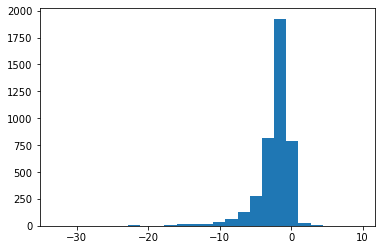

In [94]:
plt.hist(df_result_session['Sales_PE'], bins=25)


In [95]:
df_result_session_true = only_enough_stat(df_result_session)


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   2.,   1.,
          1.,   6.,   8.,  11.,  21.,  16.,  27.,  36.,  59., 104., 198.,
        494., 887., 505.]),
 array([-33.0577  , -31.743096, -30.428492, -29.113888, -27.799284,
        -26.48468 , -25.170076, -23.855472, -22.540868, -21.226264,
        -19.91166 , -18.597056, -17.282452, -15.967848, -14.653244,
        -13.33864 , -12.024036, -10.709432,  -9.394828,  -8.080224,
         -6.76562 ,  -5.451016,  -4.136412,  -2.821808,  -1.507204,
         -0.1926  ]),
 <BarContainer object of 25 artists>)

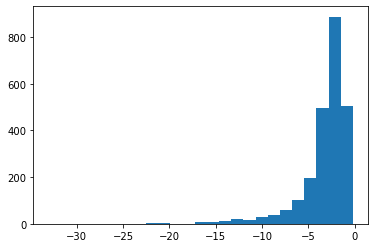

In [96]:
plt.hist(df_result_session_true['Sales_PE'], bins=25)

(array([1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 3.00e+00, 4.00e+00, 4.00e+00, 5.00e+00,
        7.00e+00, 1.20e+01, 7.00e+00, 1.50e+01, 1.30e+01, 3.00e+01,
        7.10e+01, 1.64e+02, 4.04e+02, 1.10e+03, 4.95e+02, 3.70e+01,
        8.00e+00]),
 array([-6.9329  , -6.624444, -6.315988, -6.007532, -5.699076, -5.39062 ,
        -5.082164, -4.773708, -4.465252, -4.156796, -3.84834 , -3.539884,
        -3.231428, -2.922972, -2.614516, -2.30606 , -1.997604, -1.689148,
        -1.380692, -1.072236, -0.76378 , -0.455324, -0.146868,  0.161588,
         0.470044,  0.7785  ]),
 <BarContainer object of 25 artists>)

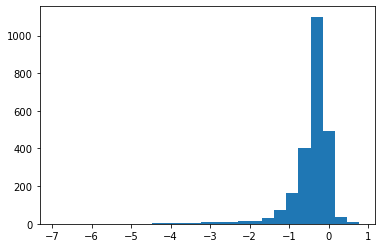

In [97]:
plt.hist(df_result_session_true['log_avg_sessions'], bins=25)


(array([1.000e+00, 0.000e+00, 4.000e+00, 6.000e+00, 7.000e+00, 6.000e+00,
        7.000e+00, 2.500e+01, 7.500e+01, 2.960e+02, 1.763e+03, 1.570e+02,
        1.500e+01, 6.000e+00, 4.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([-0.8441  , -0.767592, -0.691084, -0.614576, -0.538068, -0.46156 ,
        -0.385052, -0.308544, -0.232036, -0.155528, -0.07902 , -0.002512,
         0.073996,  0.150504,  0.227012,  0.30352 ,  0.380028,  0.456536,
         0.533044,  0.609552,  0.68606 ,  0.762568,  0.839076,  0.915584,
         0.992092,  1.0686  ]),
 <BarContainer object of 25 artists>)

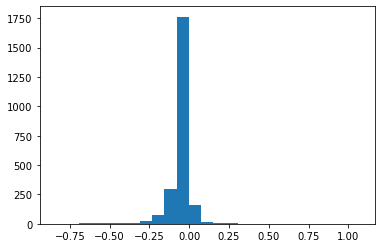

In [100]:
plt.hist(df_result_session_true['del_week'], bins=25)

In [103]:
obtain_stats(df_result_session_true,'std_session')

Model results:  std_session
Number of items =  2380
Max value =  Sales_PE   -0.193
dtype: float64 , Min value = Sales_PE   -33.058
dtype: float64
intercept
Mean
 26.329 ± 0.459
Median
  20.173 ±  0.575


Sales_PE
Mean
 -3.227 ± 0.056
Median
  -2.427 ±  0.07


del_week
Mean
 -0.048 ± 0.002
Median
  -0.033 ±  0.002


log_avg_sessions
Mean
 -0.439 ± 0.011
Median
  -0.31 ±  0.014




In [ ]:
###INTRODUCING THE REST
print(df_result_true_final.head(1000))
print(df_result_true_final.dtypes)

In [ ]:
#PREPARE THE CONVERSION RATE FILE
#final_items = list(df_result_true.index.values)
final_items = list(df_result_true_final.index.values)
print(len(final_items))



In [ ]:
print(df_filt.head(10))

In [ ]:
#df_final = df_filt[['item_code','max_date','item_price_x','conv_rate','avg_sales', 'avg_unique_views']]

#print(df_final.head())

In [ ]:
df_final= df_filt[df_filt['item_code'].isin(final_items)]

In [ ]:
print(df_final.head())

In [ ]:
df_to_spark = df_final.groupby(['item_code']).nth(-1)
df_to_spark.reset_index(level=0,inplace=True)
df_to_spark.rename(columns={'index':'item_code'}, inplace=True)
spark_check = spark.createDataFrame(df_to_spark)


In [ ]:
spark_check.show()

In [ ]:
spark_df = spark.createDataFrame(df_final)

In [ ]:
spark_df.createOrReplaceTempView('Final_table')


In [ ]:
spark_last_price = spark.sql("""with max_price as (SELECT item_code, ROW_NUMBER() over (PARTITION BY item_code ORDER BY max_date DESC) as rn, item_price_x, max_date
                            from Final_table)
                            SELECT item_code, item_price_x, max_date
                            from max_price
                            where rn=1
                            """)
spark_last_price.show()

In [ ]:
spark_last_price.createOrReplaceTempView('last_price')


In [ ]:
spark_check.createOrReplaceTempView('check_last_price')


In [ ]:
disjoint_spark = spark.sql("""SELECT *
                                from check_last_price as clp
                                inner join last_price as lp on lp.item_code = clp.item_code and lp.item_price_x!= clp.item_price_x  """)

disjoint_spark.show()

In [ ]:
spark_filter = spark.sql("""SELECT ft.item_code, AVG(ft.conv_rate) as avg_conv_rate, MAX(ft.item_price_x) as last_price, MAX(ft.max_date) as last_date, AVG(avg_unique_views) as avg_unique_views
                            from Final_table as ft
                            inner join last_price as lp on lp.item_code = ft.item_code and lp.item_price_x = ft.item_price_x
                            GROUP BY ft.item_code
                            """)
spark_filter.show()

In [ ]:
spark_filter.createOrReplaceTempView('Final_table_filt')



In [ ]:

#df_result_true.reset_index(level=0,inplace=True)
df_result_true_final.reset_index(level=0,inplace=True)



In [ ]:
df_result_true_final.rename(columns={'index':'item_code'}, inplace=True)

In [ ]:
print(df_result_true_final.head())

In [ ]:
spark_PE_df = spark.createDataFrame(df_result_true_final)

In [ ]:
spark_PE_df.show()

In [ ]:
spark_PE_df.createOrReplaceTempView('final_PE')

In [ ]:
spark_final = spark.sql("""SELECT ftf.*, fpe.Sales_PE, fpe.Sales_PE_err, fpe.del_week,fpe.del_week_err,fpe.intercept, fpe.intercept_err
                            from Final_table_filt as ftf
                            INNER JOIN final_PE as fpe on fpe.item_code = ftf.item_code""")
spark_final.show()
spark_final.createOrReplaceTempView('spark_final_tmp')

In [ ]:
spark.sql("""SELECT COUNT(DISTINCT item_code)
from spark_final_tmp""").show()



In [ ]:
#Introduce d_item table
sp_df_item = spark.read.parquet(
    '/Users/gabriele.sabato/PycharmProjects/raw_data/redshift_tables/d_item/*.parquet',
    header=True)
sp_df_item.show()

In [ ]:
#Introduce PC2 table
sp_df_pc2 = spark.read.parquet(
    '/Users/gabriele.sabato/PycharmProjects/raw_data/redshift_tables/f_item_status_last/*.parquet',
    header=True)
sp_df_pc2.show()

In [ ]:
sp_df_item.createOrReplaceTempView('d_item_tmp')
sp_df_pc2.createOrReplaceTempView('d_item_pc2')

In [ ]:
pc2_table = spark.sql(""" WITH pc2_avg as (
                            SELECT item_skey,
                            item_pc2_costs_before_cogs as pc2
                            from d_item_pc2
                            where shop_skey = 1)
                            SELECT pc.item_skey,di.item_code, pc.pc2
                            from d_item_tmp as di
                            INNER JOIN pc2_avg as pc on pc.item_skey = di.item_skey
                            where di.item_code like '0%'
                            """)
pc2_table.show()


In [ ]:
pc2_table.createOrReplaceTempView('pc2_table')

In [ ]:
spark.sql("""SELECT COUNT(DISTINCT item_skey) FROM pc2_table""").show()
spark.sql("""SELECT COUNT(item_skey) FROM pc2_table""").show()

In [ ]:
spark_pc2_final = spark.sql(""" SELECT sp.*, pc.pc2, pc.item_skey
                                from spark_final_tmp as sp
                                 INNER JOIN pc2_table as pc on sp.item_code = pc.item_code
                                 """)

spark_pc2_final.show()

In [ ]:
df_final_spark = spark_pc2_final.toPandas()

In [ ]:
df_final_spark.to_csv('./pickle_files/df_final_spark_top5k_Sales_20210507.csv')